In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA

In [2]:
# Set data input folder
# Download files described in README.md to this folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [4]:
# Import the HeLa gene-level profiles
df_gene_DMEM = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___DMEM___ALLWELLS_gene_aggregated.csv.gz")
df_gene_DMEM = df_gene_DMEM.set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
df_gene_HPLM = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___HPLM___ALLWELLS_gene_aggregated.csv.gz")
df_gene_HPLM = df_gene_HPLM.set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')

# Load p_values from the hit calling process
df_p_values_DMEM = pd.read_csv('../Hit_Calling/outputs/HeLa_DMEM_significant_features_mann_whitney_p_values.csv.gz')
df_p_values_DMEM = df_p_values_DMEM.set_index('Gene')
df_p_values_HPLM = pd.read_csv('../Hit_Calling/outputs/HeLa_HPLM_significant_features_mann_whitney_p_values.csv.gz')
df_p_values_HPLM = df_p_values_HPLM.set_index('Gene')

# Import annotated gene sets
with open("../common_files/annotated_gene_sets.json") as f:
    gene_set_dict = json.load(f)

# Load expression data 
with open("../Hit_Calling/outputs/HeLa_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']

# Figure 4A

In [12]:
for p_values, condition in [(df_p_values_DMEM,'DMEM'),(df_p_values_HPLM,'HPLM')]:
    # Calculate the morphological signal scores for each perturbation and sort 
    p_values = p_values.loc[expressed_gene_list[:-1]]
    p_values_neg_log = -np.log10(p_values)
    ranked_list = pd.DataFrame(((p_values <= 0.001) * p_values_neg_log).sum(axis=1).sort_values(ascending=False))
    ranked_list = ranked_list.reset_index().rename(columns={'Gene':'GID',0:''})
    ranked_list.to_csv(os.path.join(output_folder,f'HeLa_{condition}_all_genes.rnk'), sep='\t', index=False)
ranked_list.head()

GID             
0  ATP2A2  7208.687082
1    RAC1  6368.172435
2   EIF4E  6367.152512
3    WDR3  6235.943880
4    YRDC  6225.056999

# Figures 4B and 4C

In [17]:
# Perform principal component analysis on gene aggregated profiles
df_gene_pca_dict = {}
for (df_gene, condition) in [(df_gene_DMEM, 'DMEM'), (df_gene_HPLM, 'HPLM')]:
    pca = PCA()
    pca.fit(df_gene)
    x = list(pca.explained_variance_ratio_)
    # Find principal component that represents 70% variation
    PCA_lookup = {}
    for i in range(len(x)):
        distance = abs(.7-sum(x[:i+1]))
        PCA_lookup[distance] = i 
    component = PCA_lookup[min(PCA_lookup.keys())]+1
    print (f'For {condition}, principal component representing closest to 70% variation is {component}')
    # Perform principal component analysis and select components representing 70% of variation in data
    pca = PCA(n_components=component)
    df_gene_pca = pd.DataFrame(pca.fit_transform(df_gene),index=df_gene.index).reset_index()
    df_gene_pca_dict[condition] = df_gene_pca
df_gene_pca.head()

For DMEM, principal component representing closest to 70% variation is 219
For HPLM, principal component representing closest to 70% variation is 163


Metadata_Foci_Barcode_MatchedTo_GeneCode         0         1         2  \
0                                     A1BG  1.637396  2.023461  2.438137   
1                                     A1CF  2.913357  3.394958 -1.019905   
2                                      A2M  1.684017 -2.029124 -0.886640   
3                                    A2ML1 -0.120869 -0.743938  3.113952   
4                                  A3GALT2 -2.594188 -1.895410 -0.392176   

          3         4         5         6         7         8  ...       153  \
0 -1.846398  0.727277 -2.349782  1.650778  0.445240  0.247720  ... -0.252895   
1 -1.401843  0.054735  0.024840 -0.046808 -0.015557  0.191920  ...  0.044925   
2 -4.534917 -0.015577  2.891560  0.971885 -1.244736 -1.194295  ... -0.240373   
3  0.277018 -0.771666 -0.888554 -0.615700 -0.855206 -0.944411  ... -0.283866   
4  0.401301 -3.524494  1.388321  1.795259  0.263285 -1.449055  ...  0.056003   

        154       155       156       157       158       159       160  \
0 -0.054594 -0.044783  0.496692 -0.495239  0.181324 -0.197188 -0.064220   
1 -0.248940 -0.188765 -0.037425 -0.056782  0.011326 -0.343572  0.139266   
2 -0.021736 -0.024887  0.337359 -0.115451 -0.106216  0.173470  0.046977   
3 -0.157359 -0.116066  0.241068  0.149755  0.415877 -0.016073  0.201434   
4 -0.125366  0.137767  0.113003 -0.225762 -0.158058  0.064891  0.149960   

        161       162  
0 -0.348080 -0.215085  
1  0.374069  0.225857  
2 -0.119615  0.199071  
3  0.517489  0.263758  
4 -0.189417  0.022043  

[5 rows x 164 columns]

In [18]:
def coupled_heatmap(profile_df_1,profile_df_2,gene_set,genes,naming,font_scale = 3.5):
    # Clustered based on the profile_df_1 arm first
    genes_lst = genes.split('\t')
    genes_df =  profile_df_1[profile_df_1['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_lst)]
    genes_profiles = genes_df.set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    
    # Clustered based on the profile_df_1 arm first
    data = genes_profiles.T
    corr = data.corr()

    ax = sns.clustermap(
        corr, 
        vmin=-1, vmax=1, center=0,
        method = 'ward',
        square=True,
    )

    # Clustered based on the profile_df_1 arm first
    profile_df_1_gene_list = list(genes_df.Metadata_Foci_Barcode_MatchedTo_GeneCode)

    profile_df_1_cluster_order = ax.dendrogram_row.reordered_ind
    profile_df_1_cluster_list = [profile_df_1_gene_list[i] for i in profile_df_1_cluster_order]

    profile_df_2_gene_df =  profile_df_2[profile_df_2['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(profile_df_1_cluster_list)]
    profile_df_2_gene_profiles = profile_df_2_gene_df.set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    profile_df_2_gene_profiles = profile_df_2_gene_profiles.reindex(profile_df_1_cluster_list)
    profile_df_1_gene_profiles = genes_profiles.reindex(profile_df_1_cluster_list)

    profile_df_1_data = profile_df_1_gene_profiles.T
    profile_df_1_corr = profile_df_1_data.corr()

    profile_df_2_data = profile_df_2_gene_profiles.T
    profile_df_2_corr = profile_df_2_data.corr()
    len(profile_df_1_corr)
    corr = profile_df_2_corr.copy()
    for i in range(len(profile_df_1_corr)):
        for j in range(len(profile_df_1_corr)):
            if i > j:
                corr.iat[i,j] = profile_df_1_corr.iat[i,j]
            elif i < j:
                corr.iat[i,j] = profile_df_2_corr.iat[i,j]
            elif i == j:
                corr.iat[i,j] = 1
    
    output_file = f'HeLa_median_plate_level_profile_heatmap_clustering_gene_hits_{gene_set}_{naming}.png'
    plt.clf()

    fig, ax = plt.subplots(figsize=(30, 30))
    sns.set_theme(font_scale=font_scale,rc={'figure.figsize':(30,30)})

    ax = sns.heatmap(
                corr, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
                linewidth = 1,
                linecolor='white',
                cbar=False,
                cbar_kws={"shrink": .76}
    )
    ax.set_xticklabels(
                ax.get_xticklabels(),
                rotation=90,
                horizontalalignment='right'
    )
    ax.yaxis.tick_right()
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='left')
    ax.set(xlabel="", ylabel="")

    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(output_folder,output_file),dpi=300)


/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

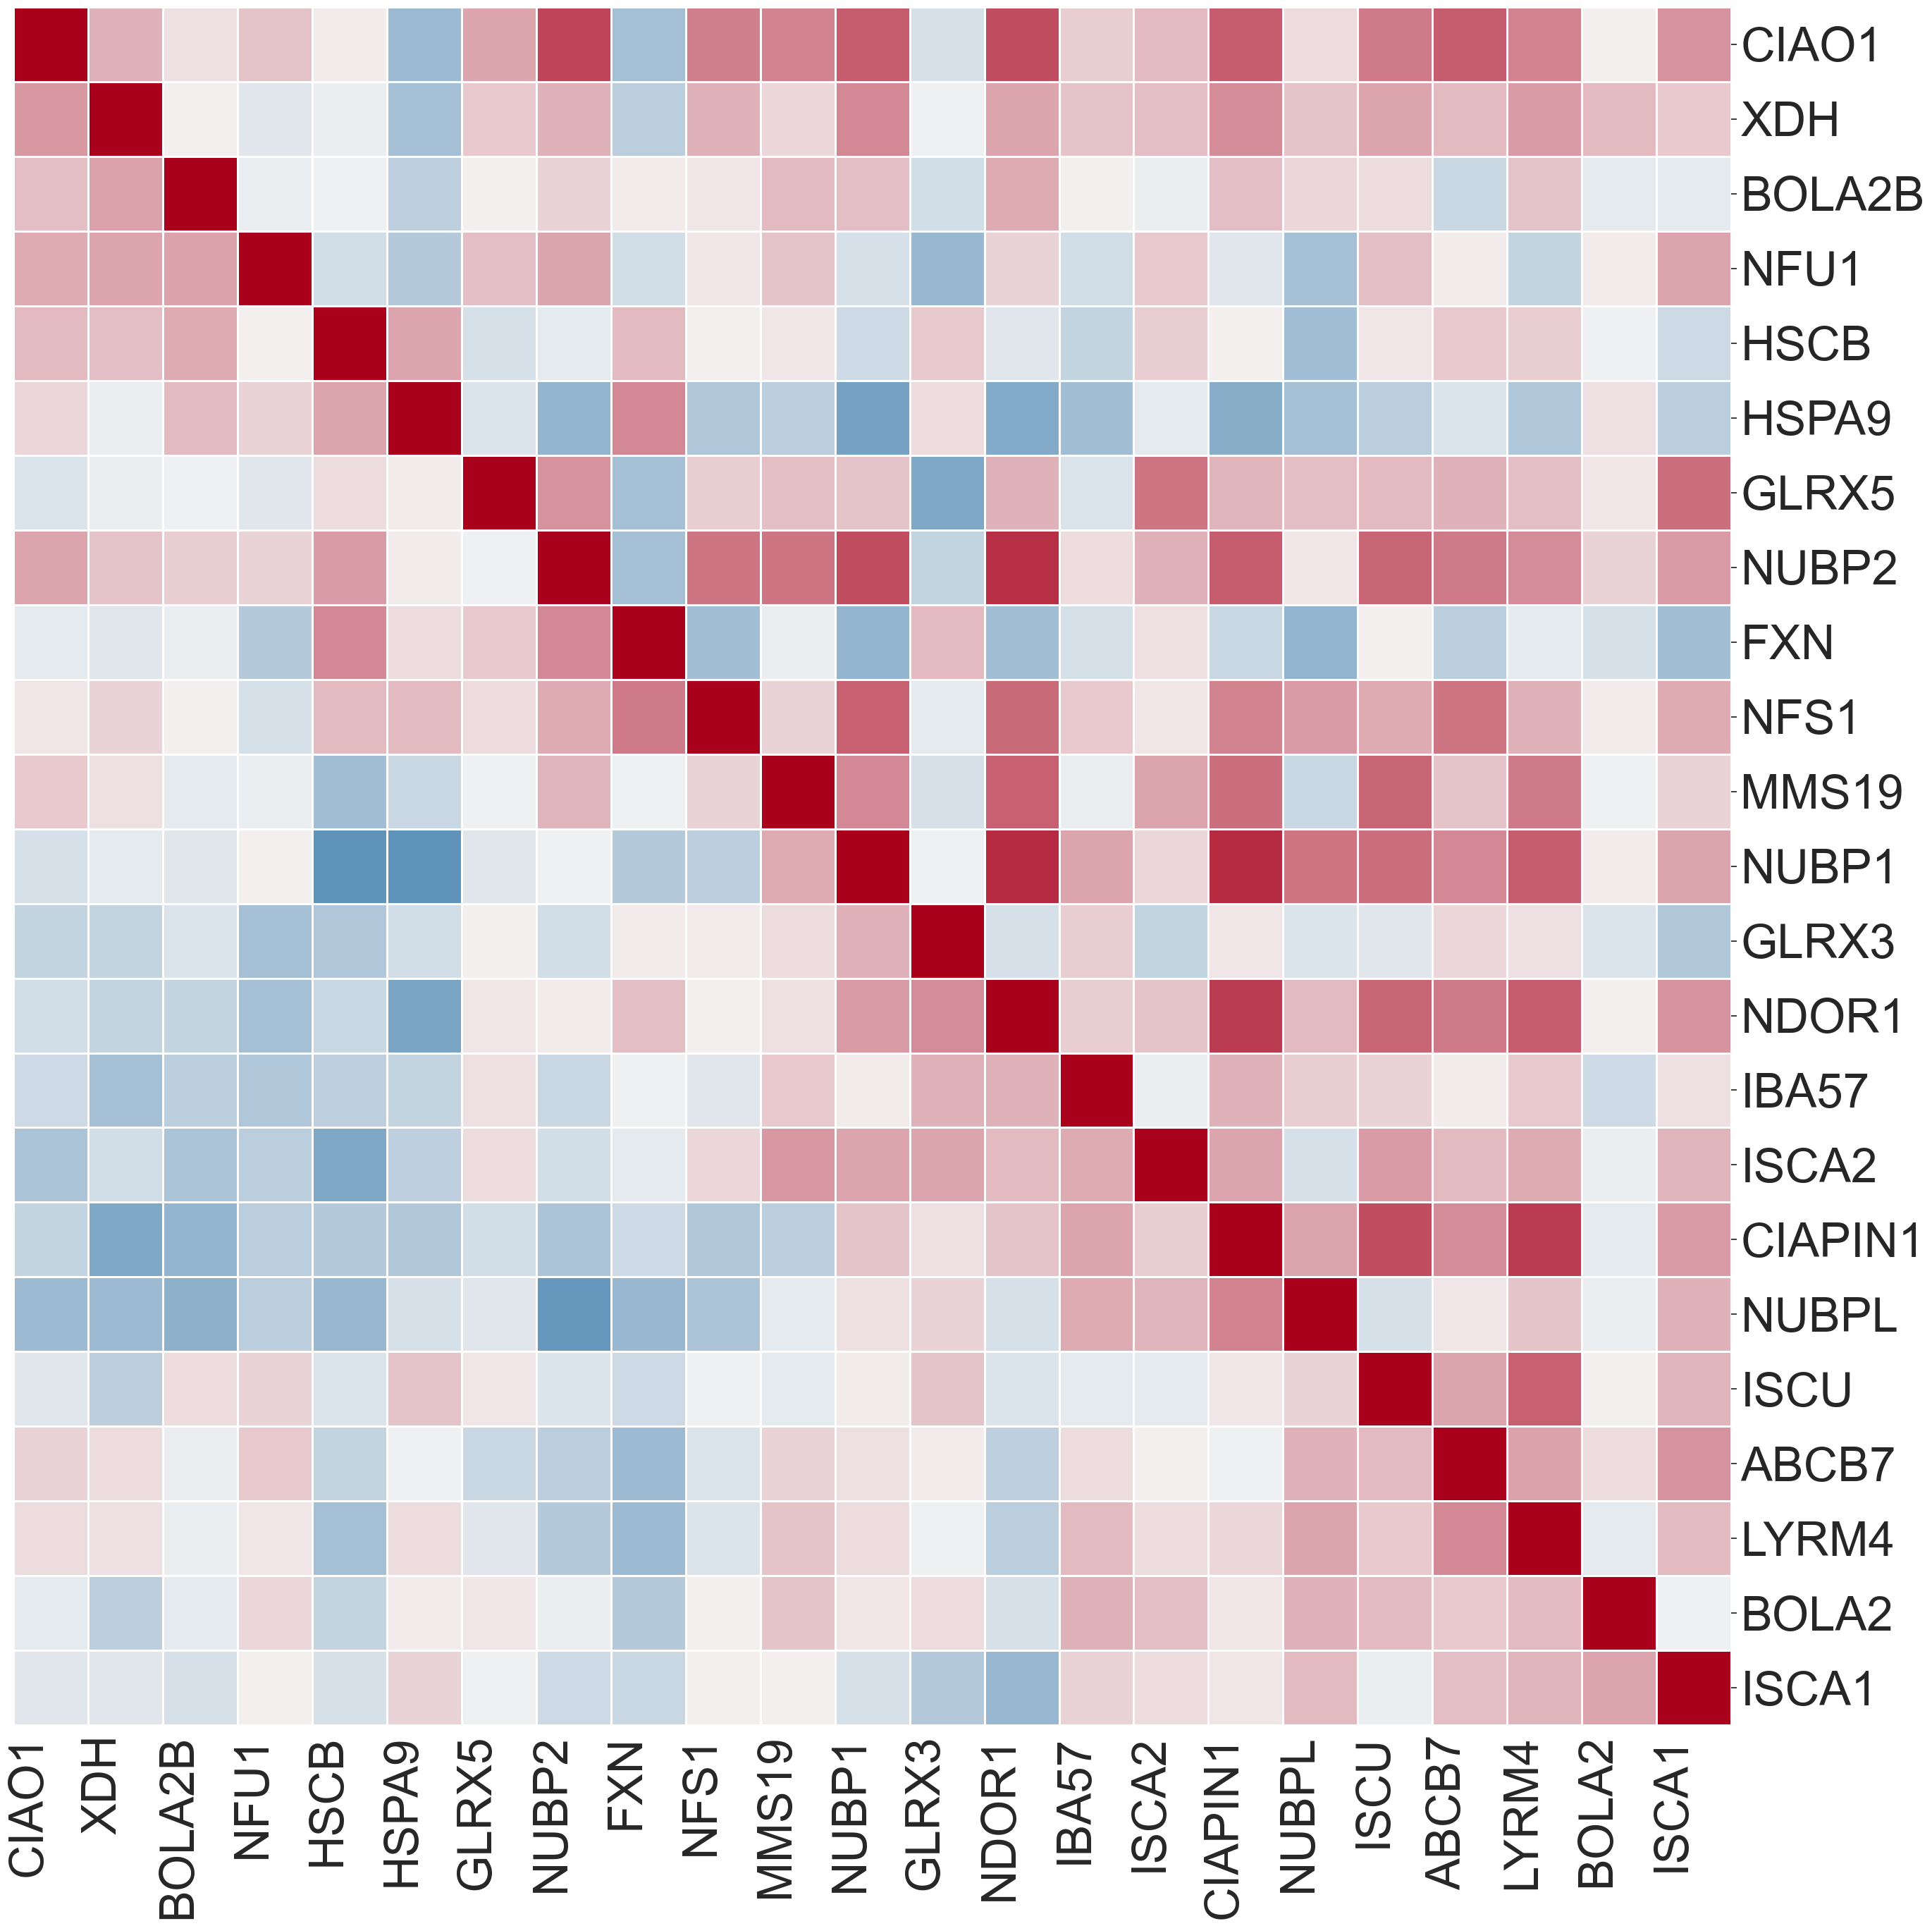

In [31]:
# Clustered based on the HPLM arm first
gene_set = 'GOBP_IRON_SULFUR_CLUSTER_ASSEMBLY_HPLM_cluster'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,'HPLM_first',genes,8)

/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

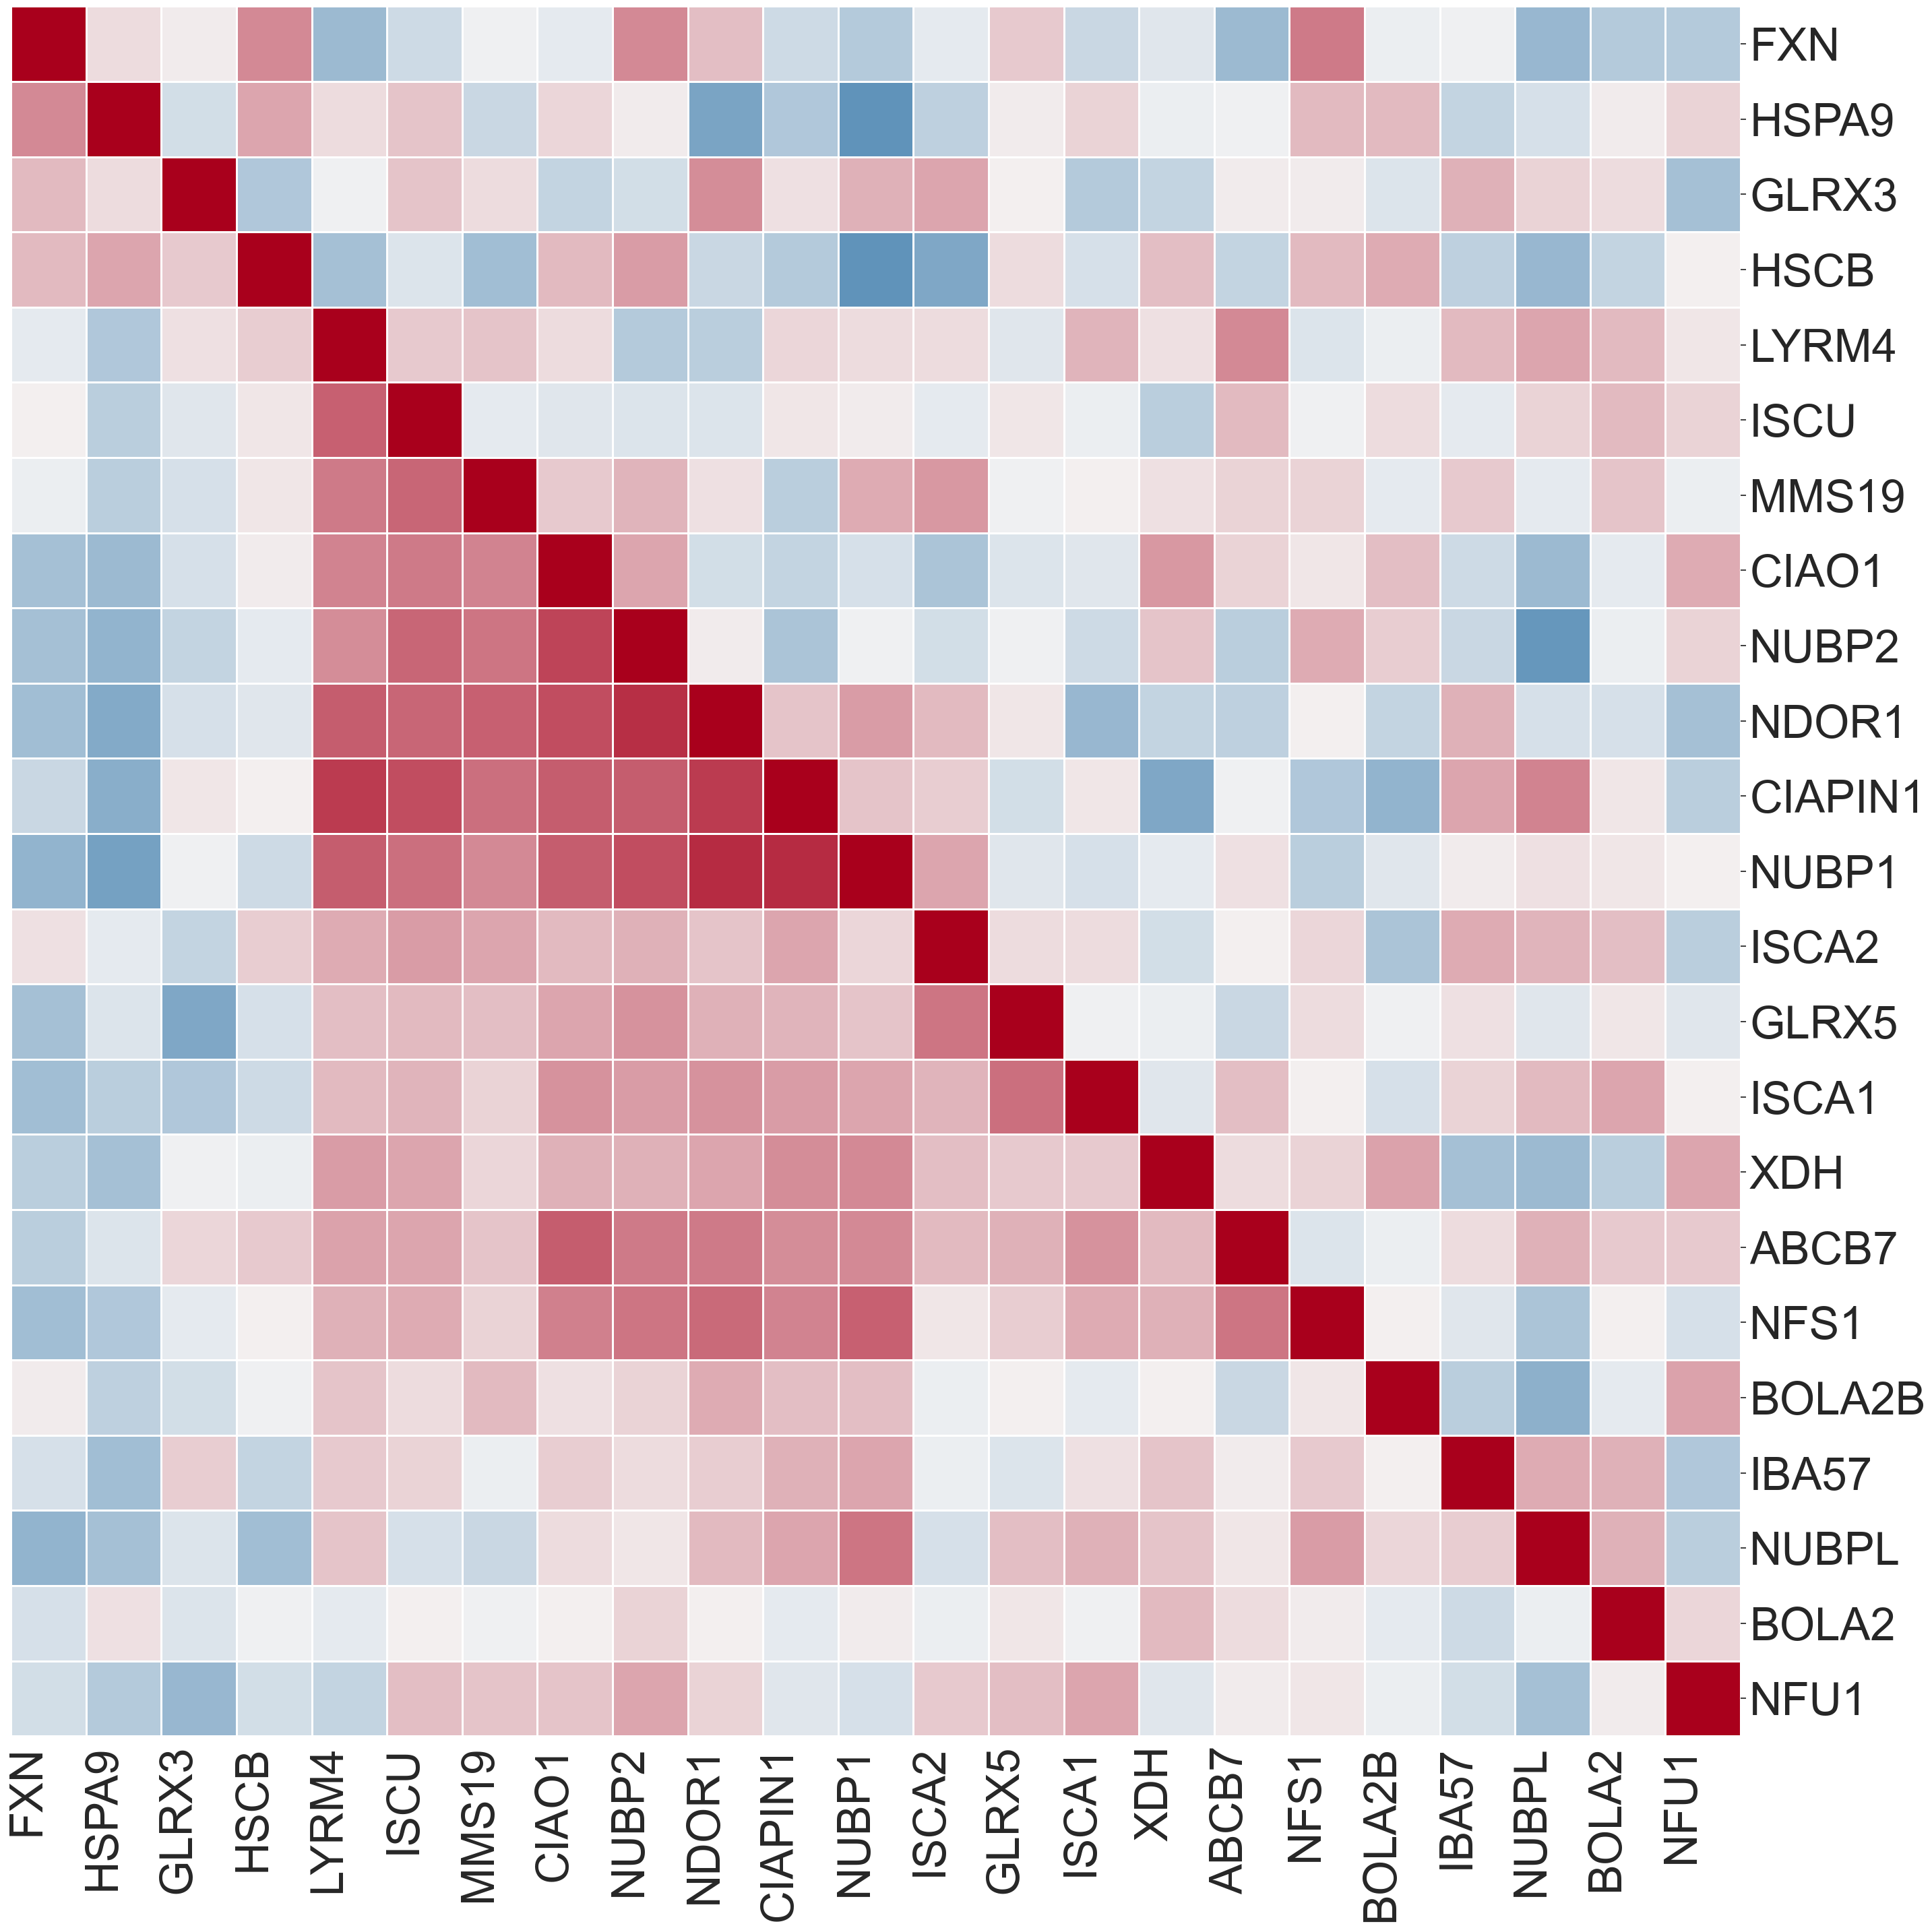

In [20]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',4.4)

/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

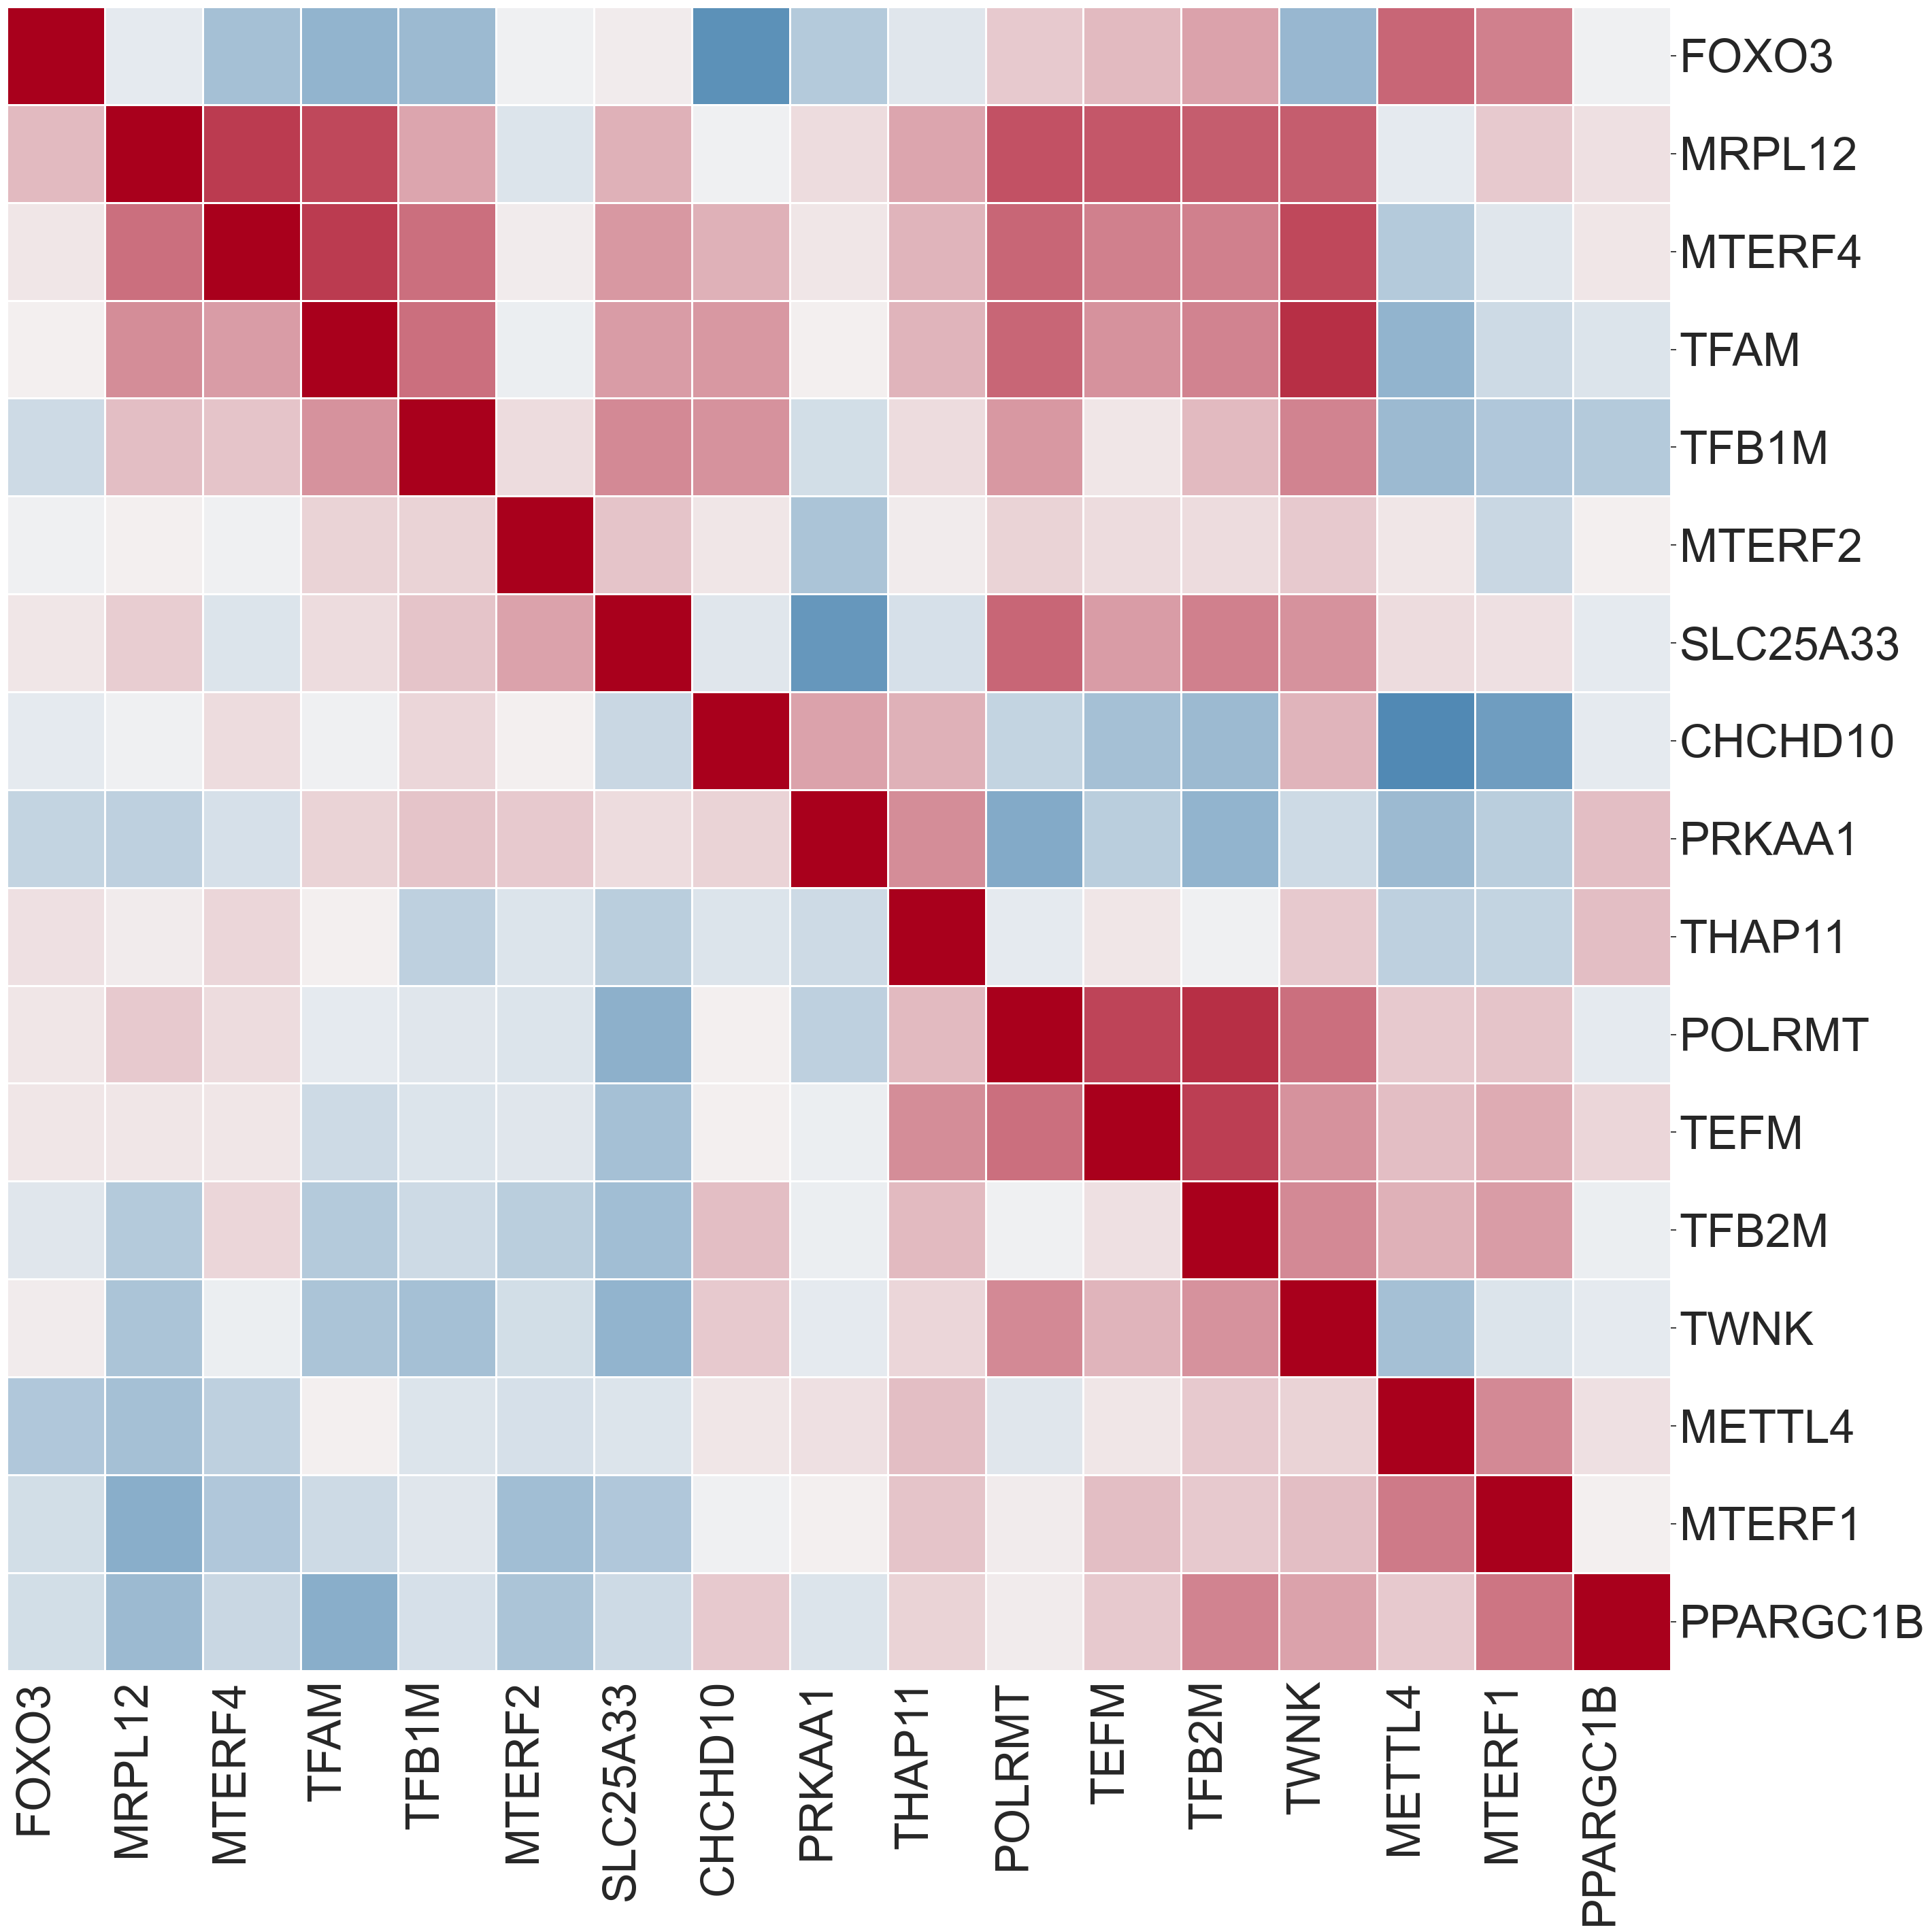

In [21]:
# Clustered based on the HPLM arm first
gene_set = 'MITOCHONDRIAL_TRANSCRIPTION'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first',5)


/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

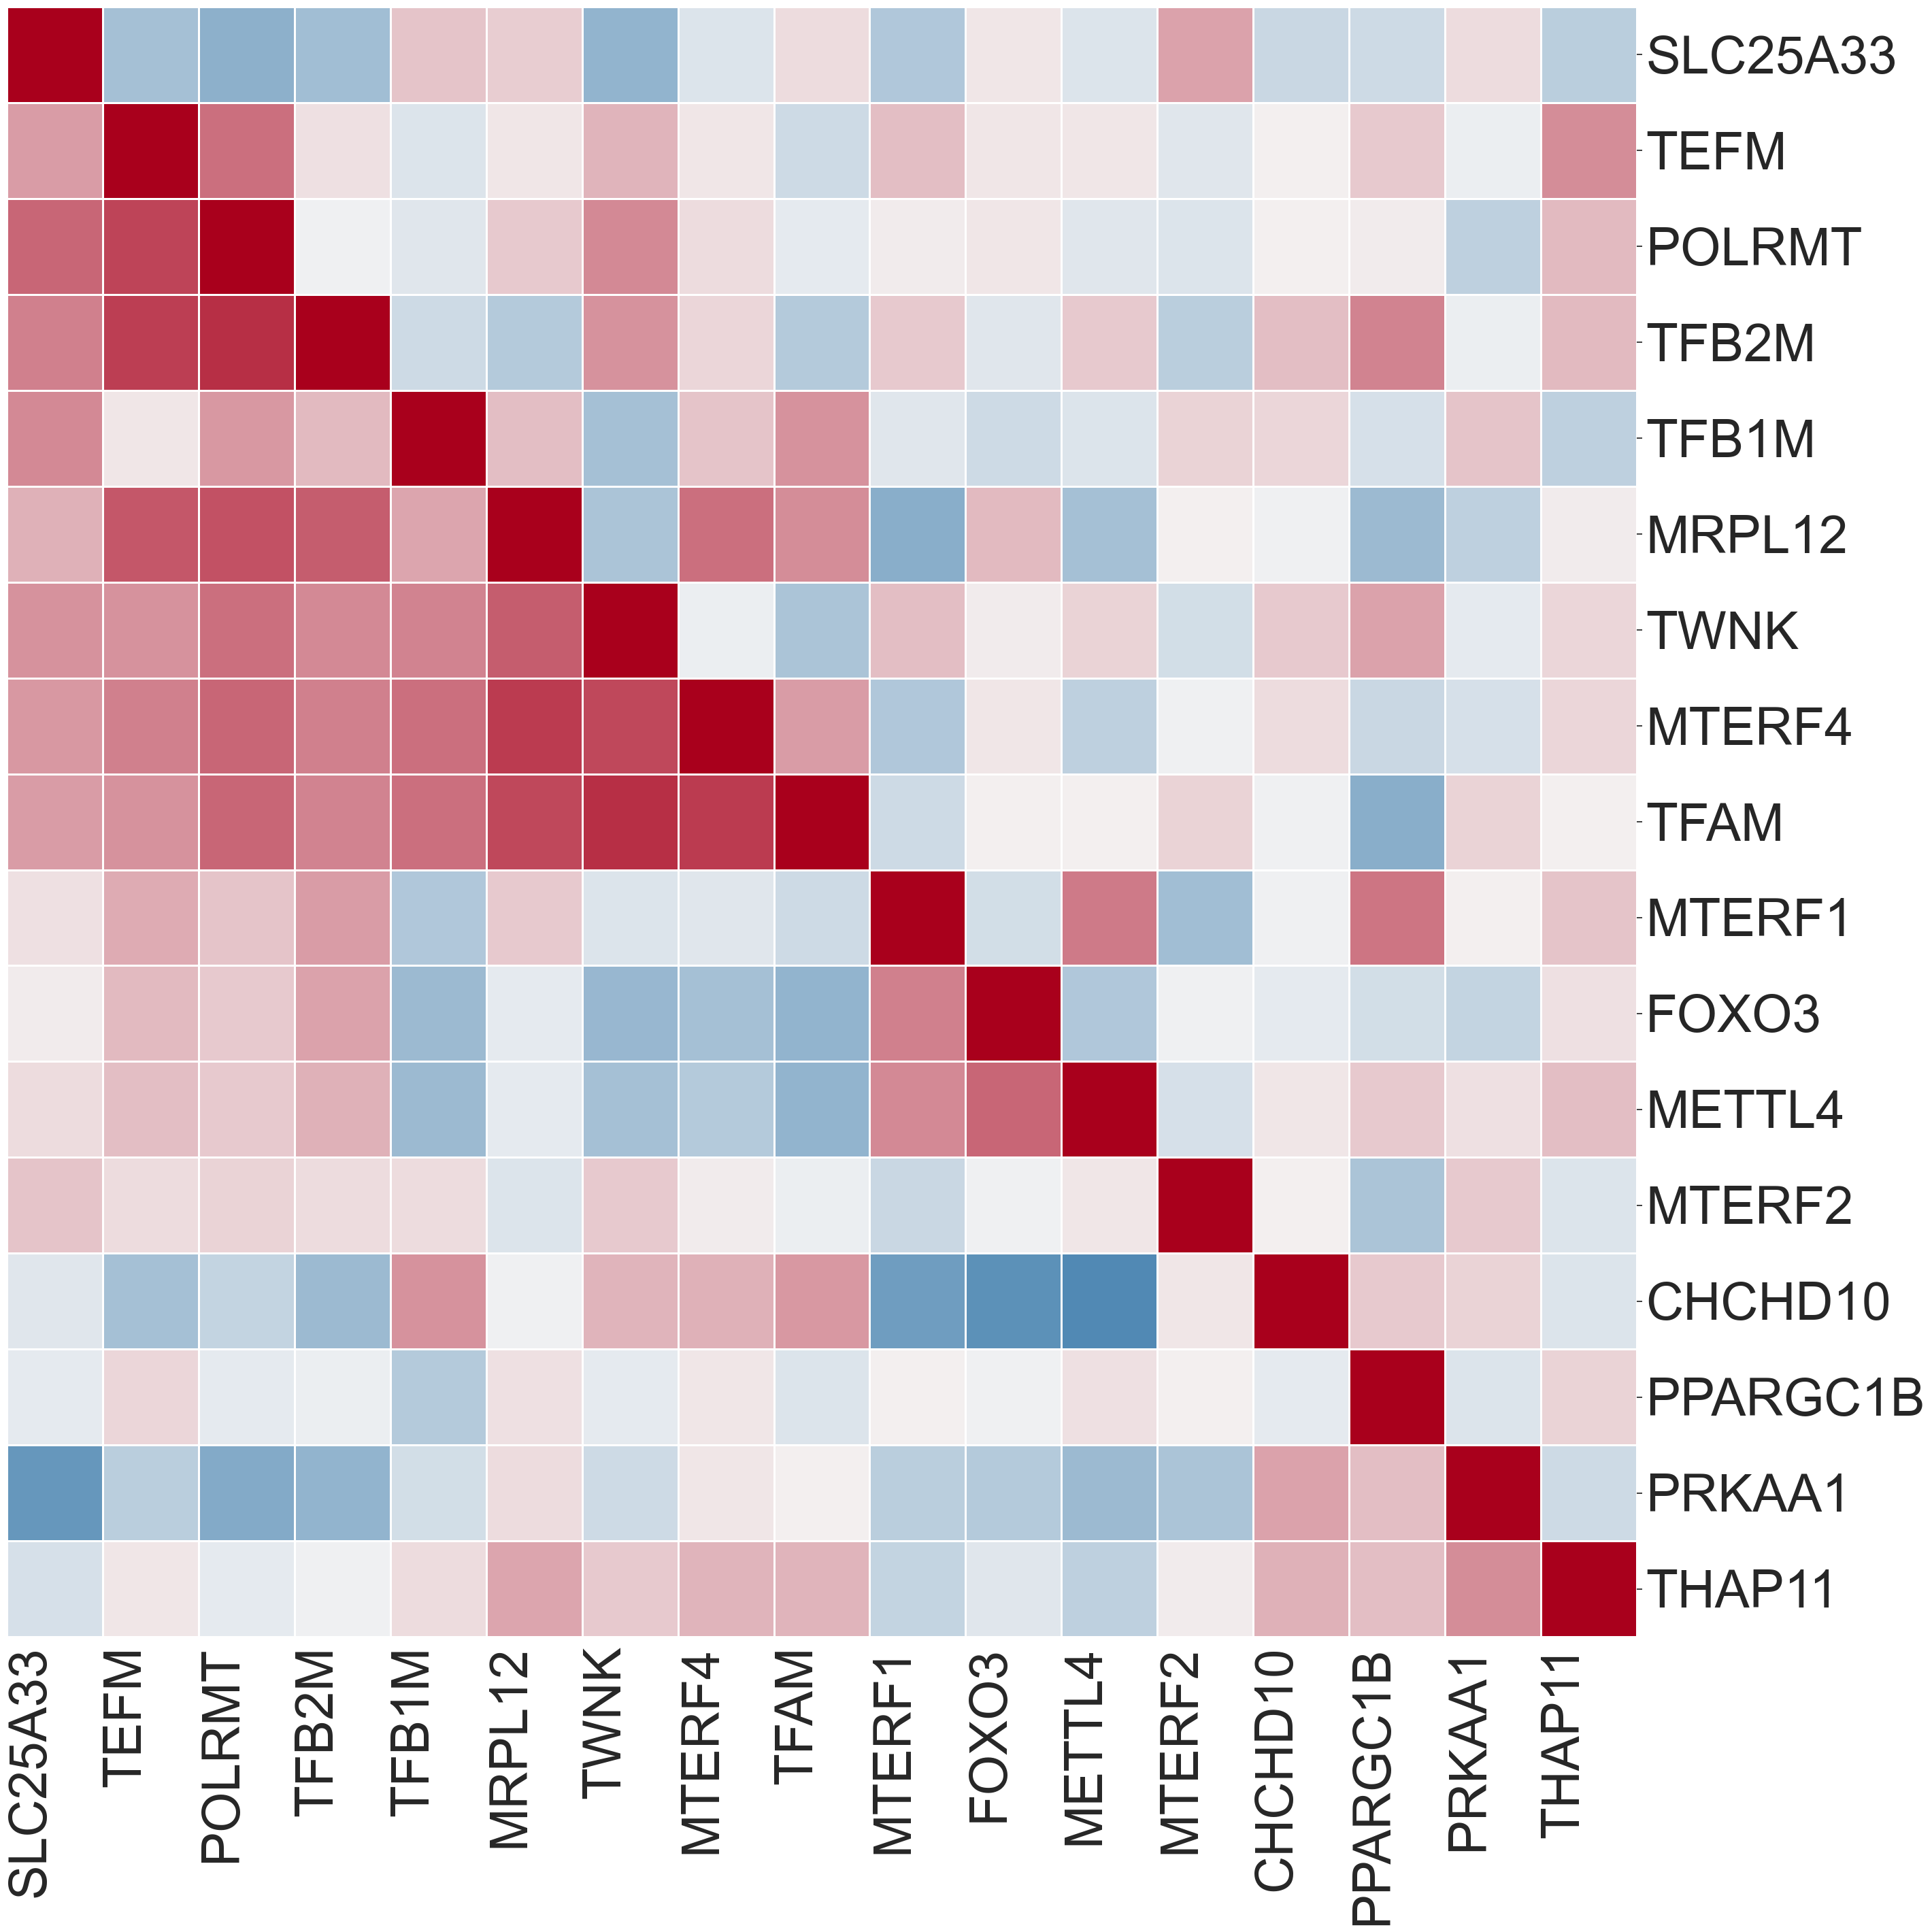

In [22]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',5)


/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

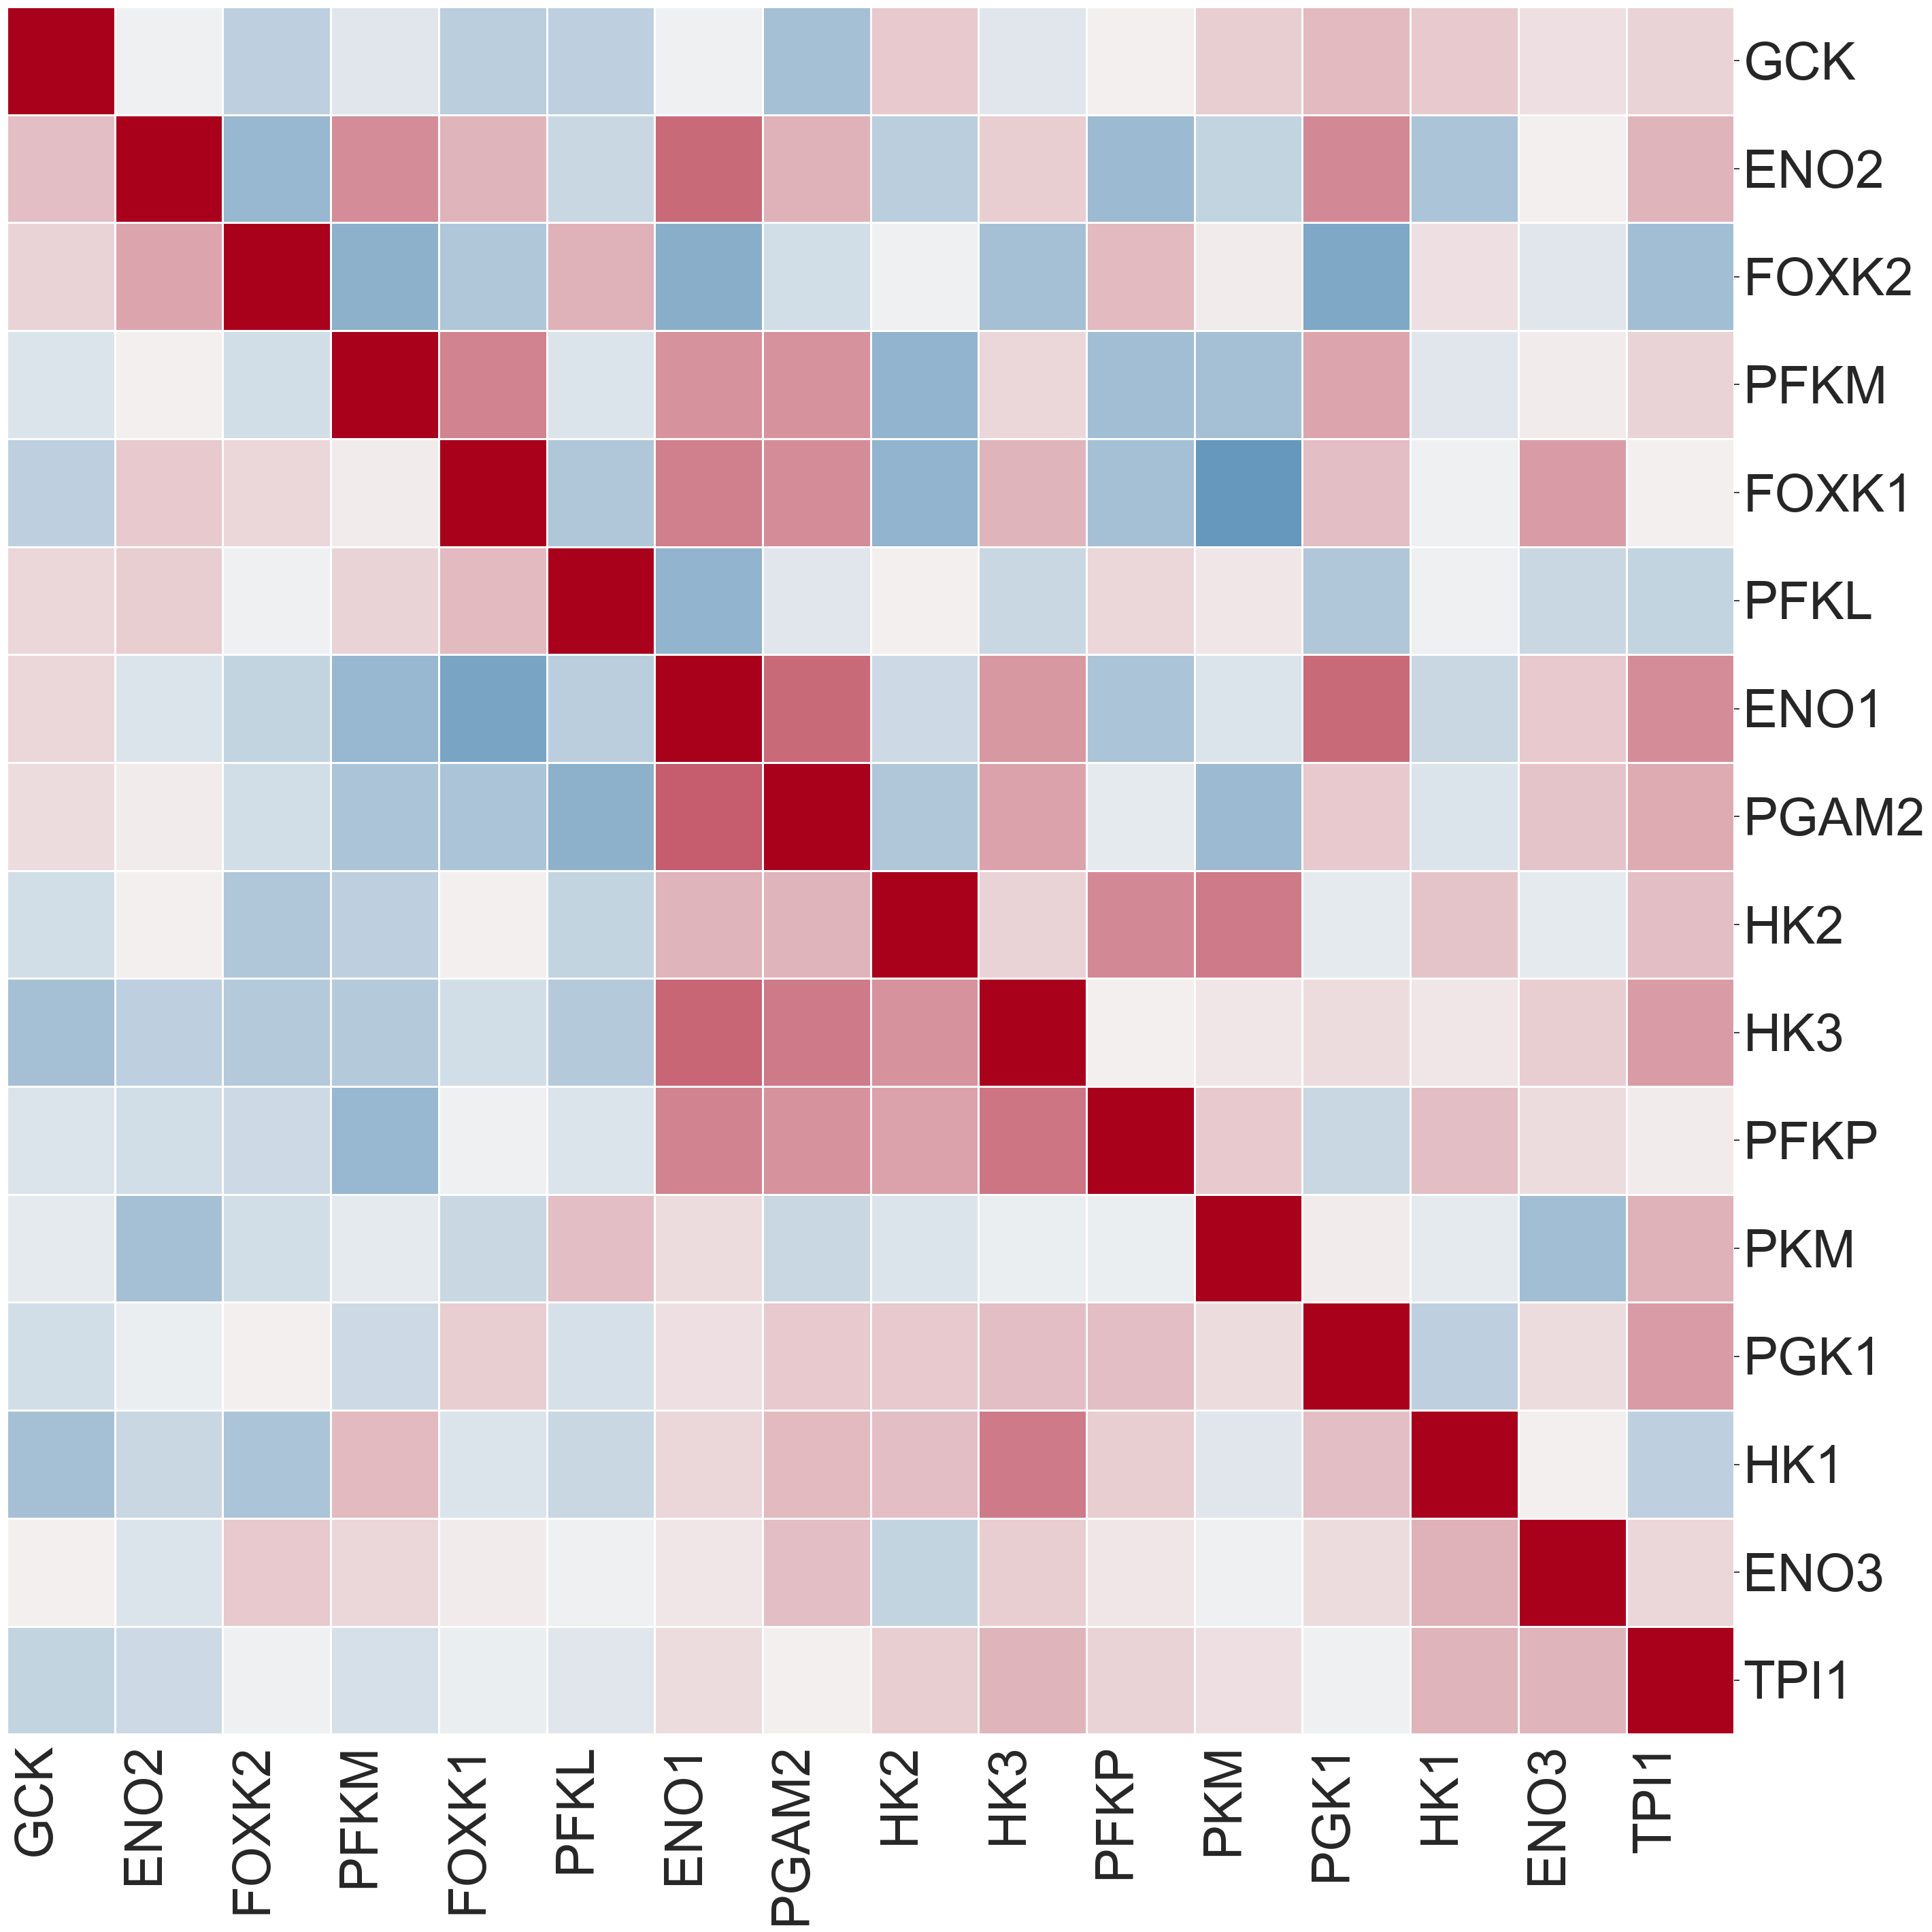

In [23]:
# Clustered based on the HPLM arm first
gene_set = 'NADH_REGENERATION'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first',5)


/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

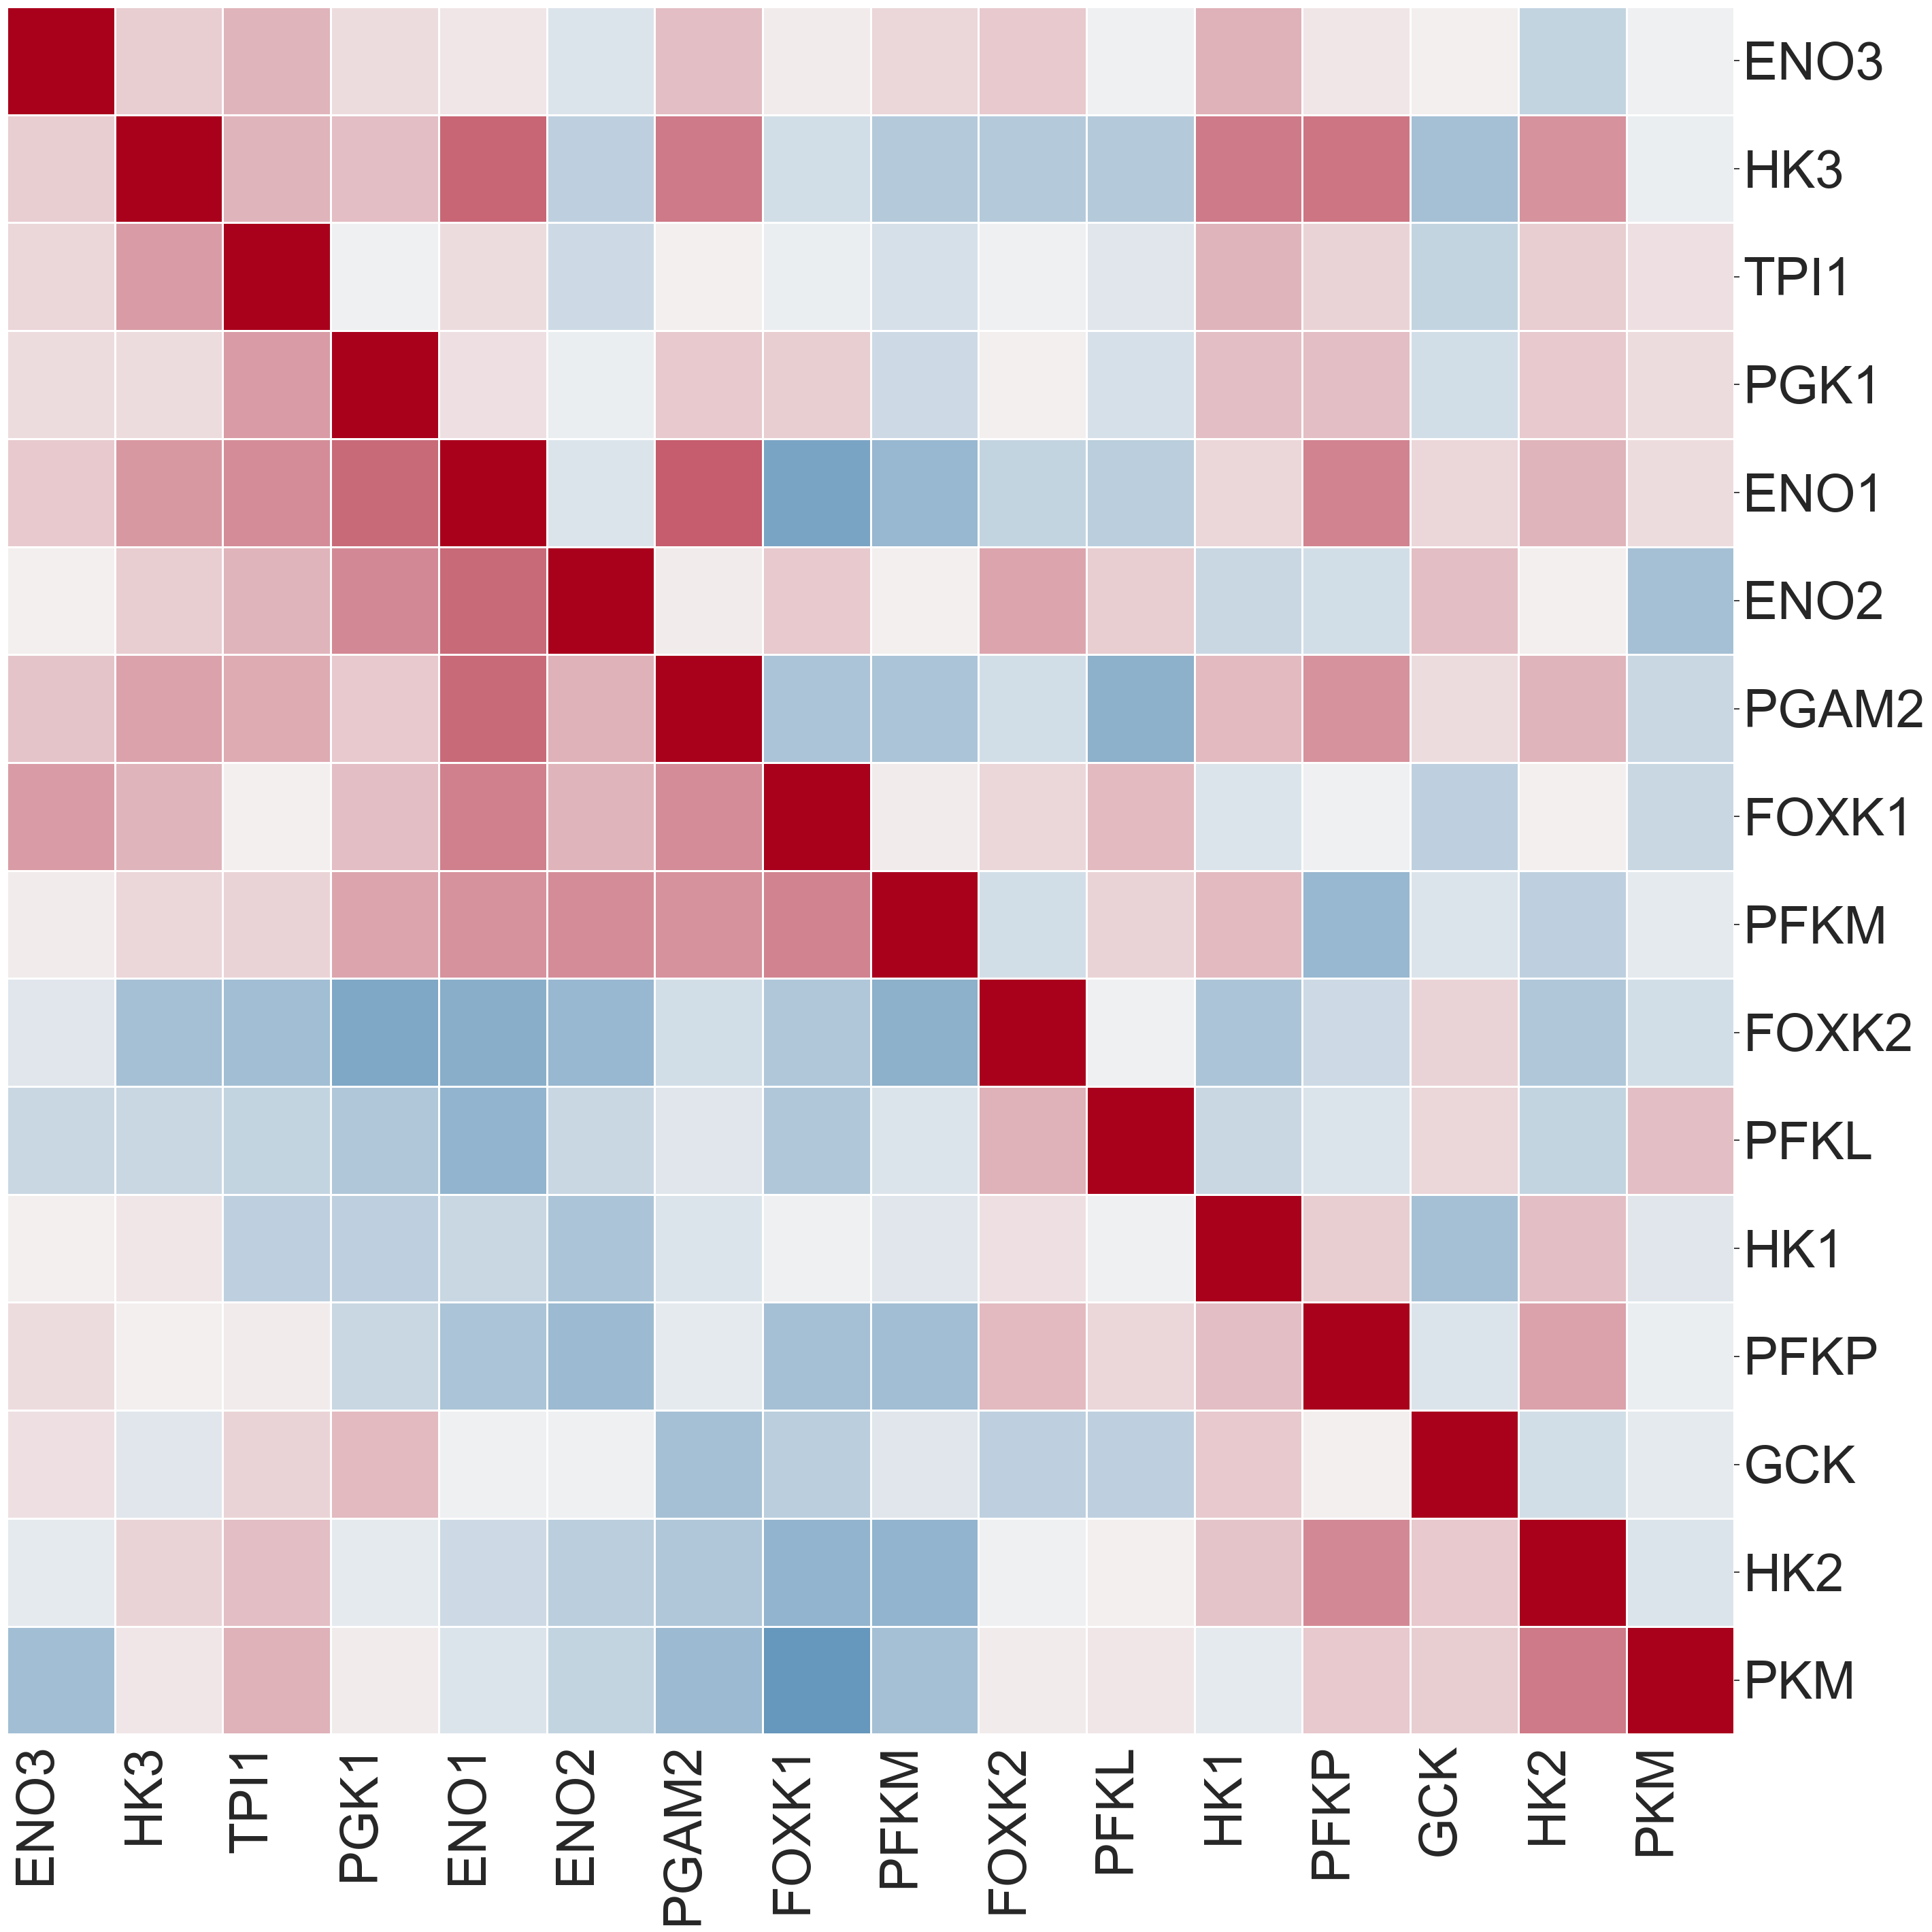

In [24]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',5)


/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

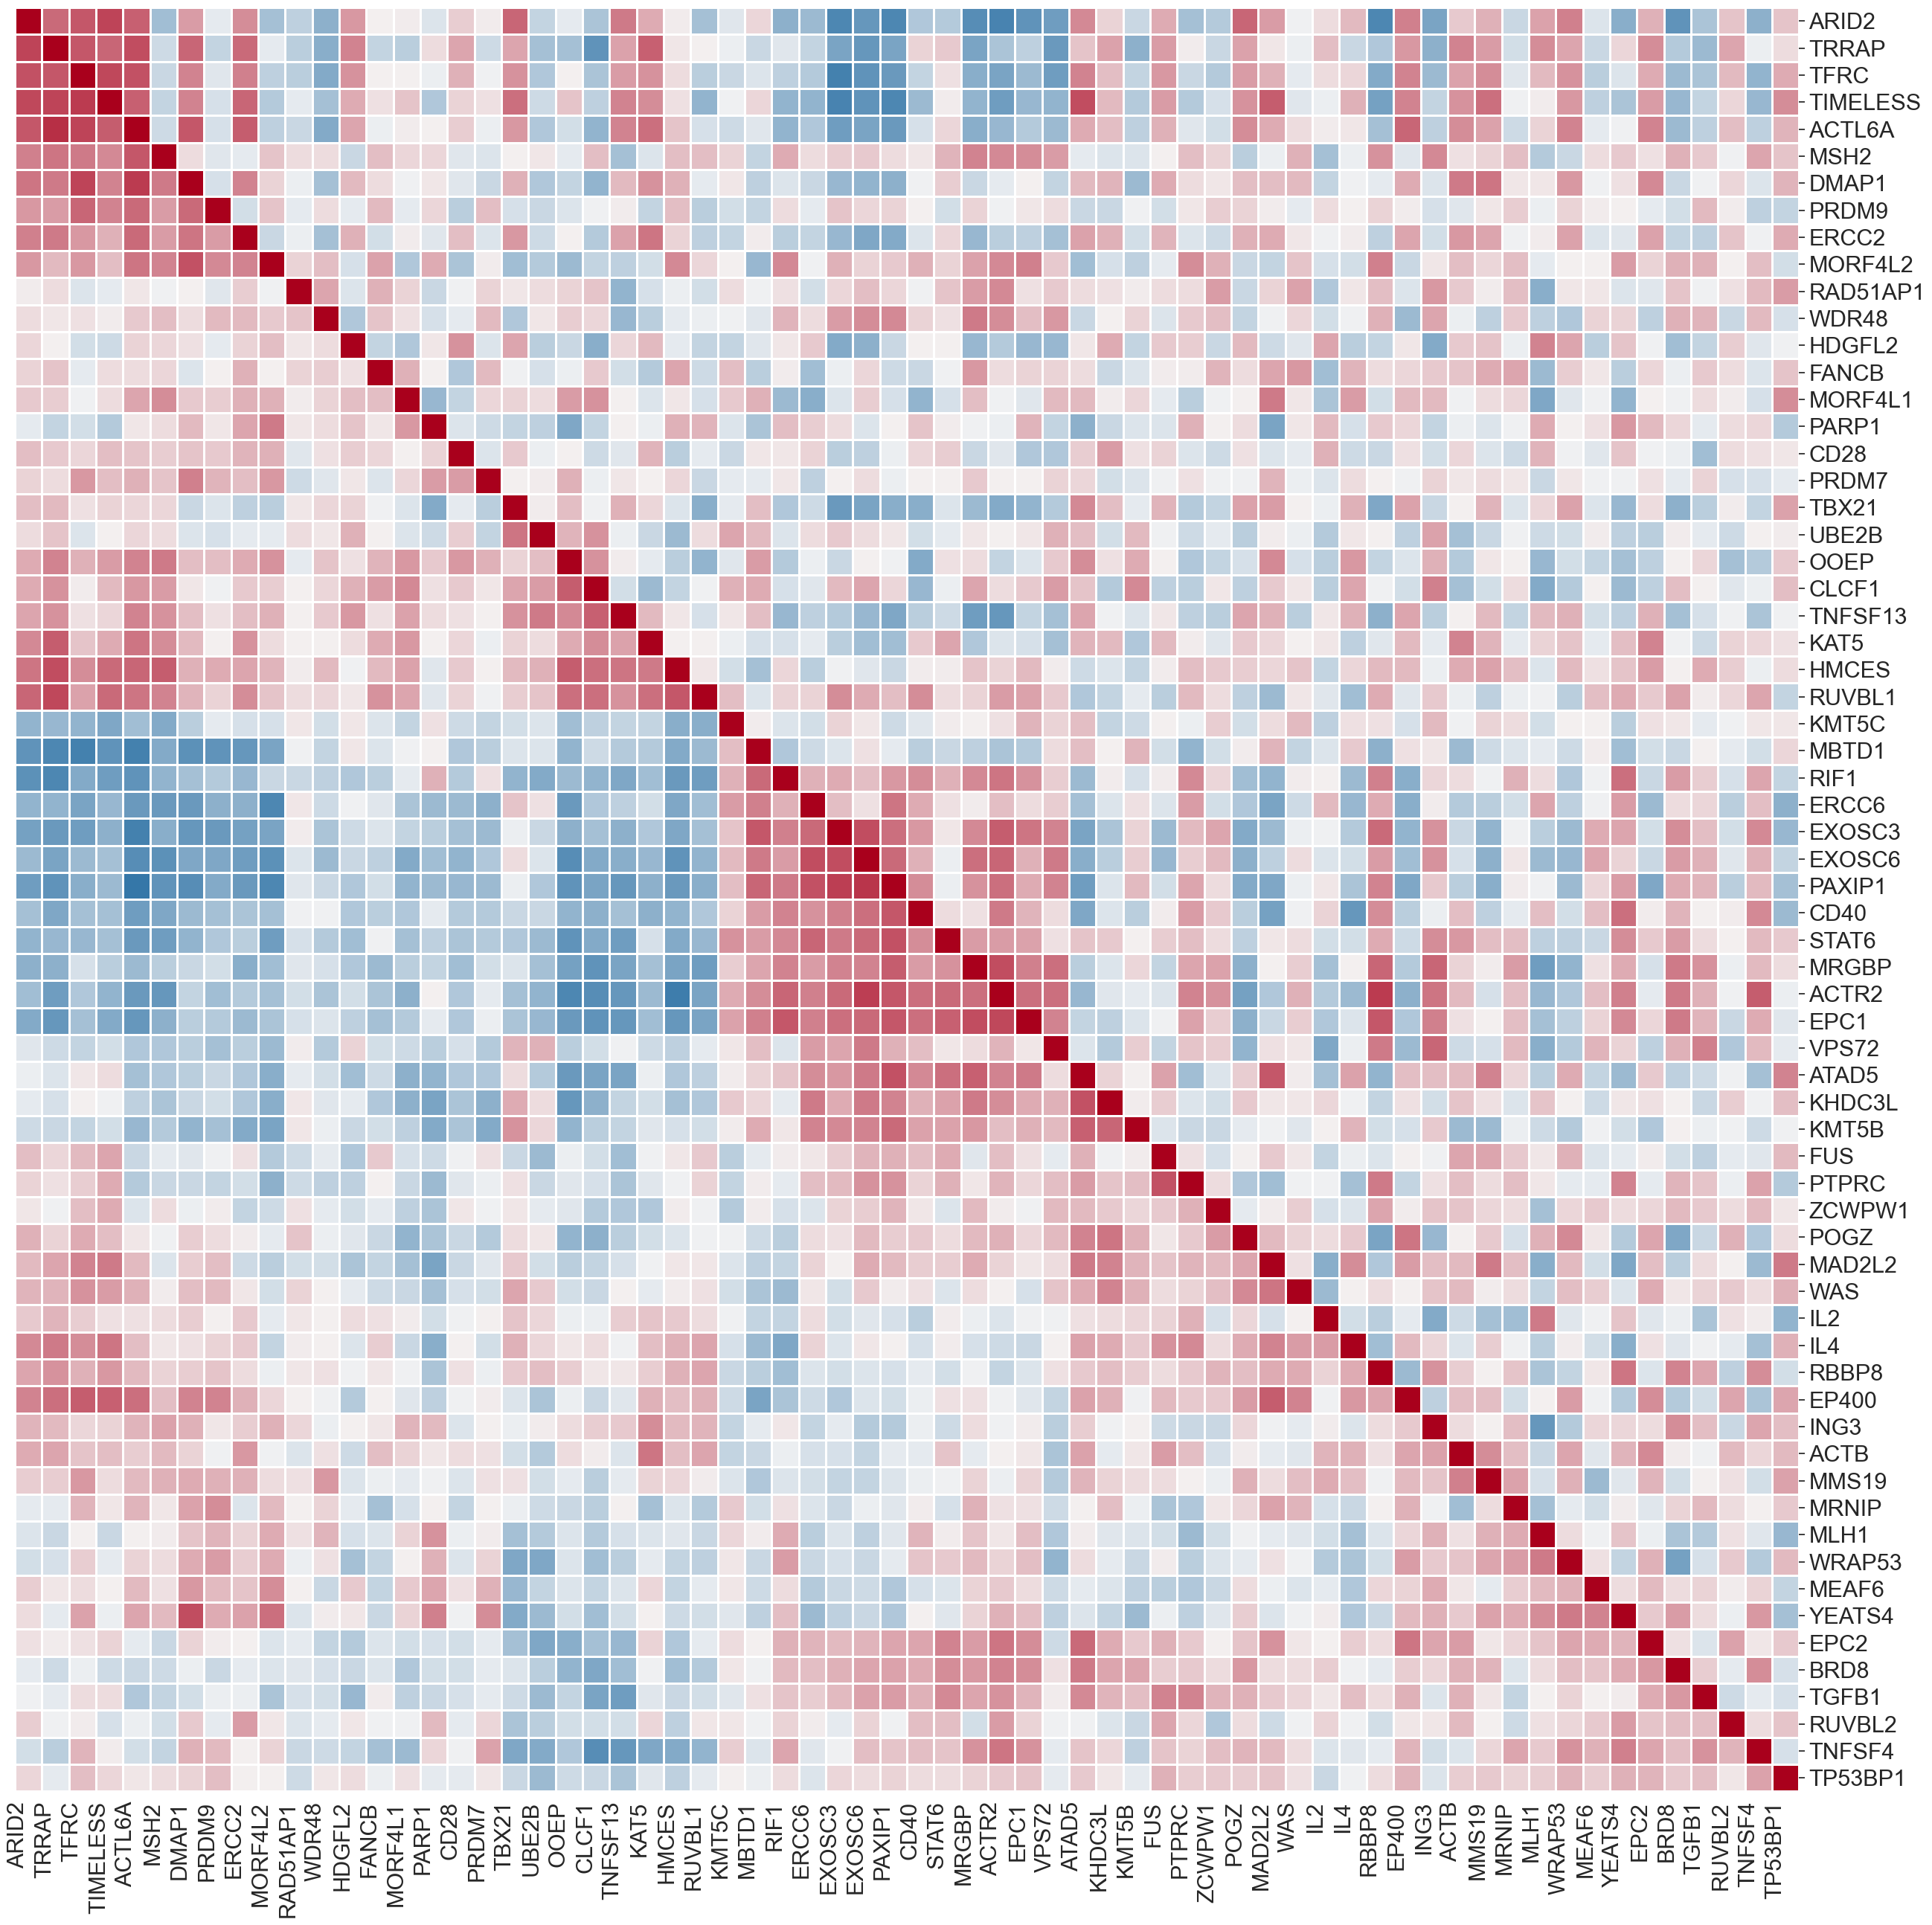

In [33]:
# Clustered based on the HPLM arm first
gene_set = 'POSITIVE_REGULATION_OF_DNA_RECOMBINATION'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first',12)

/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

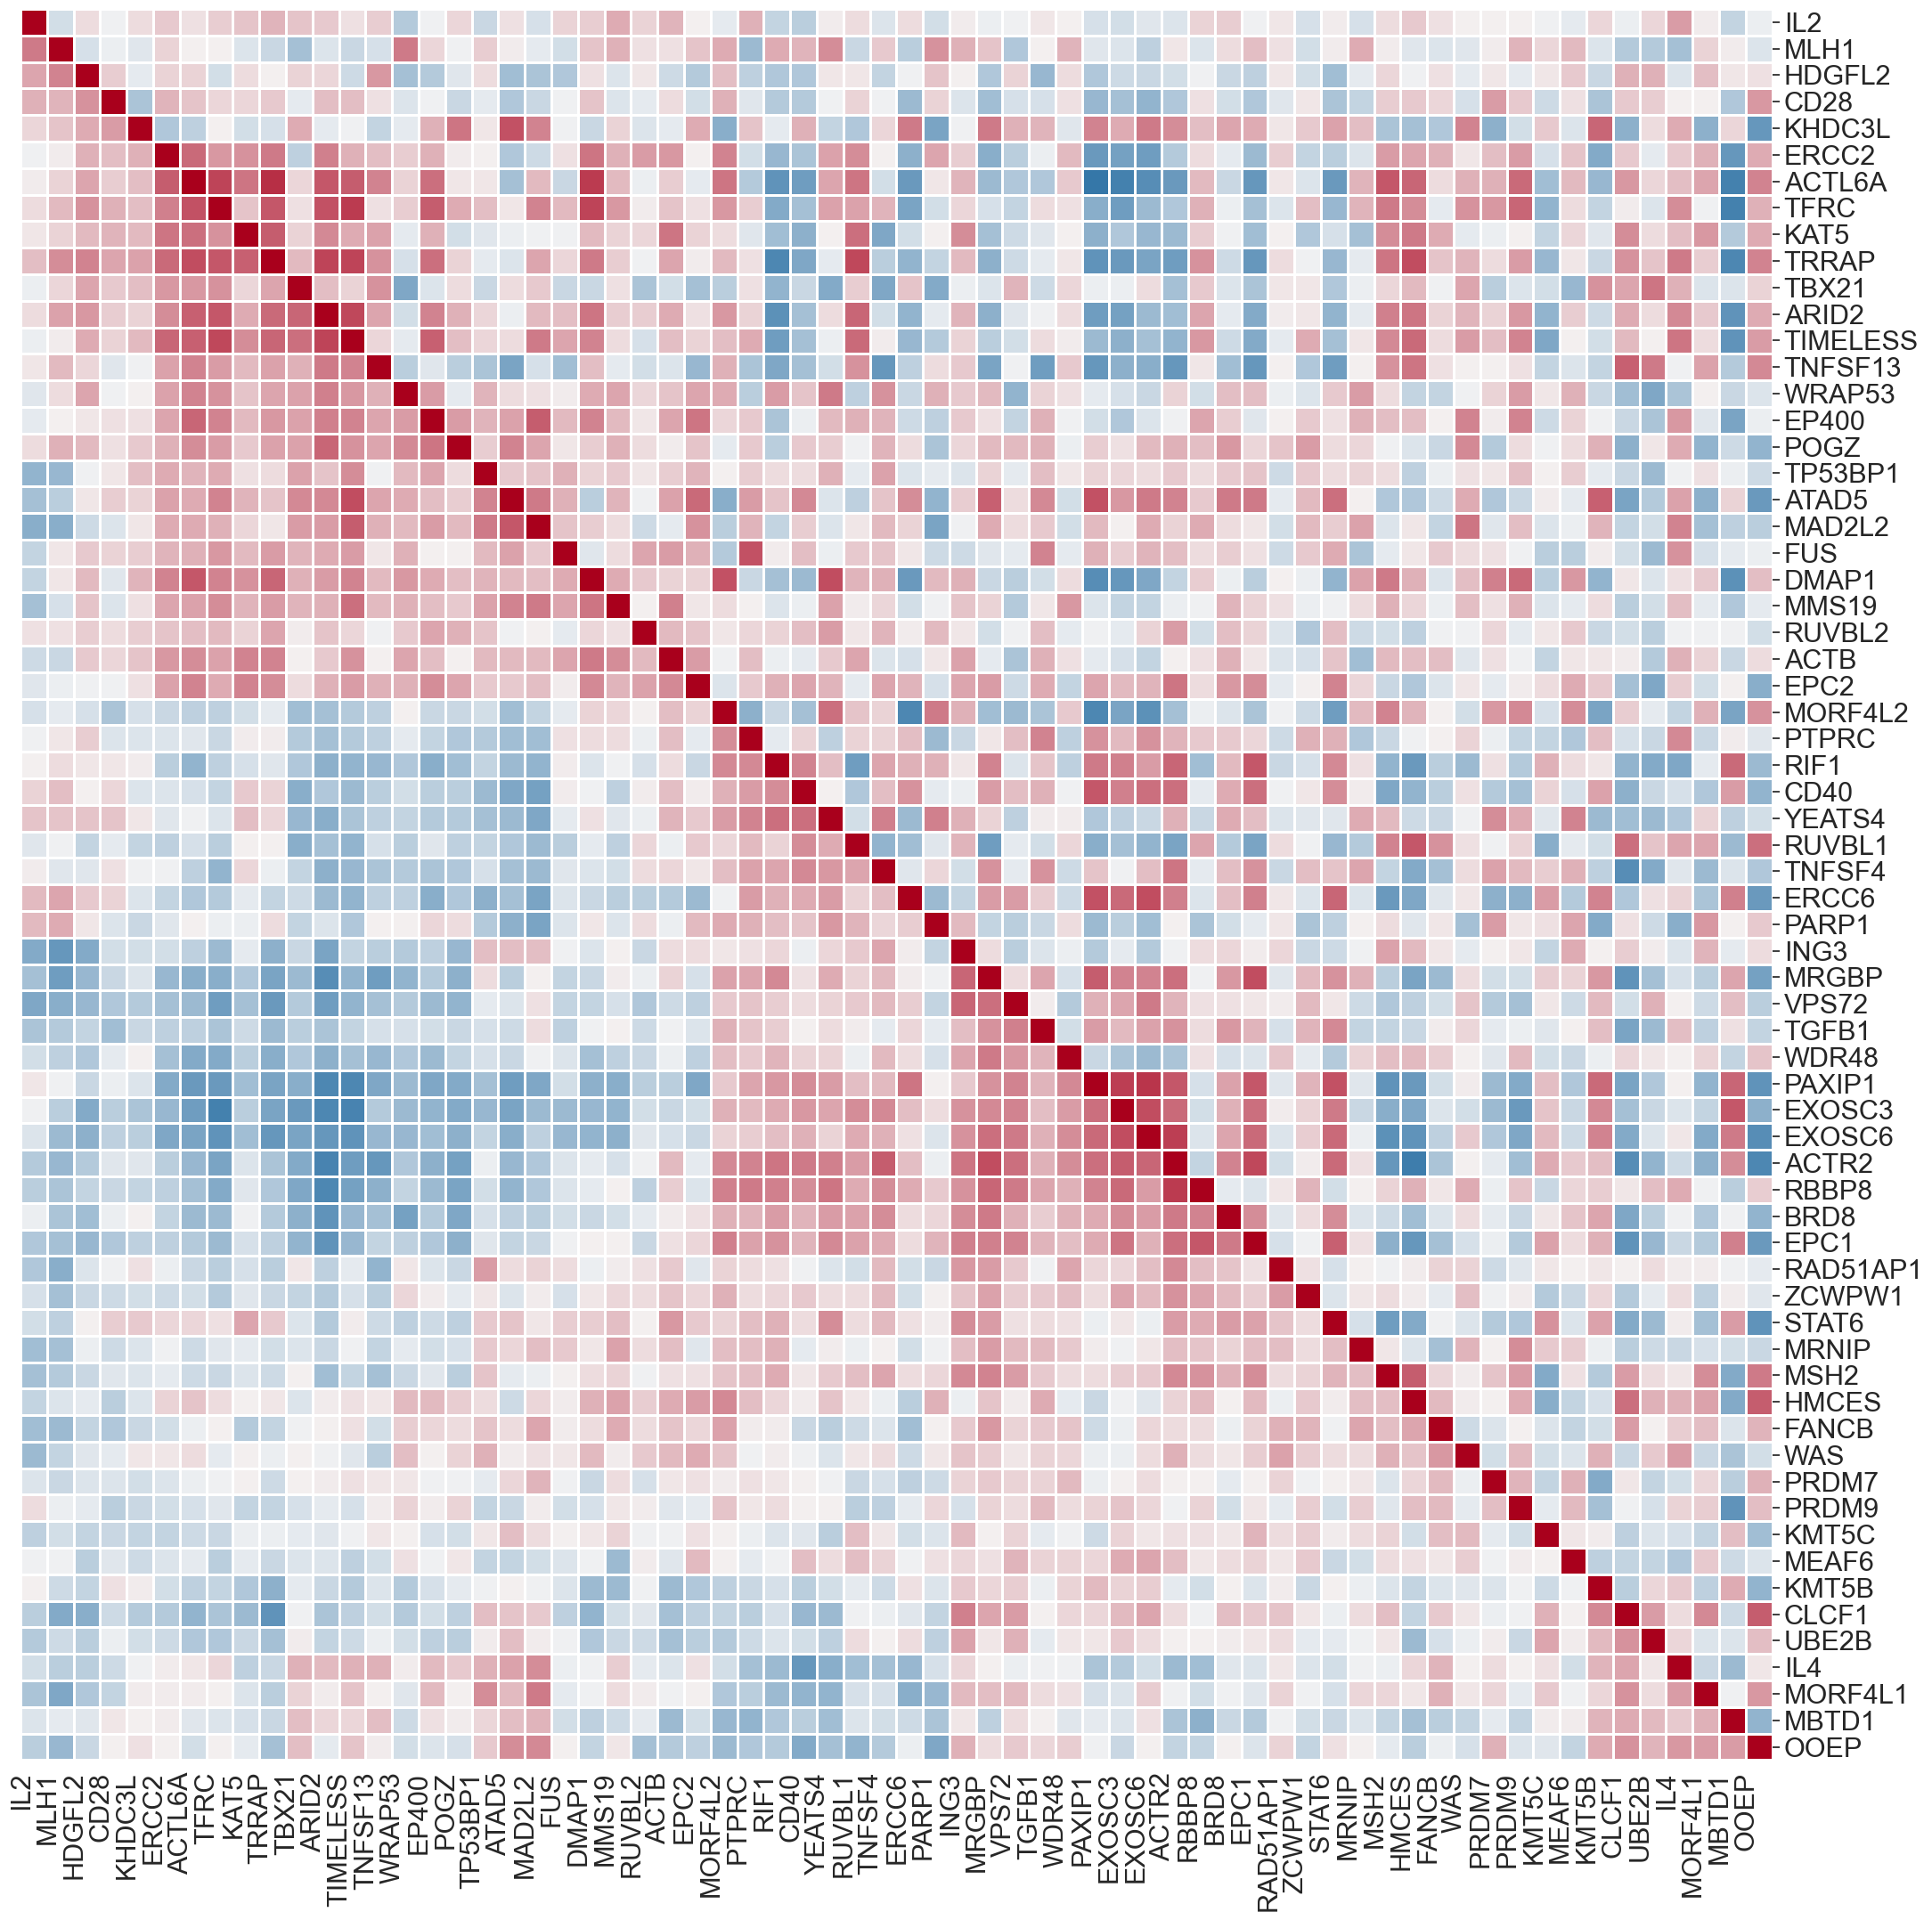

In [36]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',24)

/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

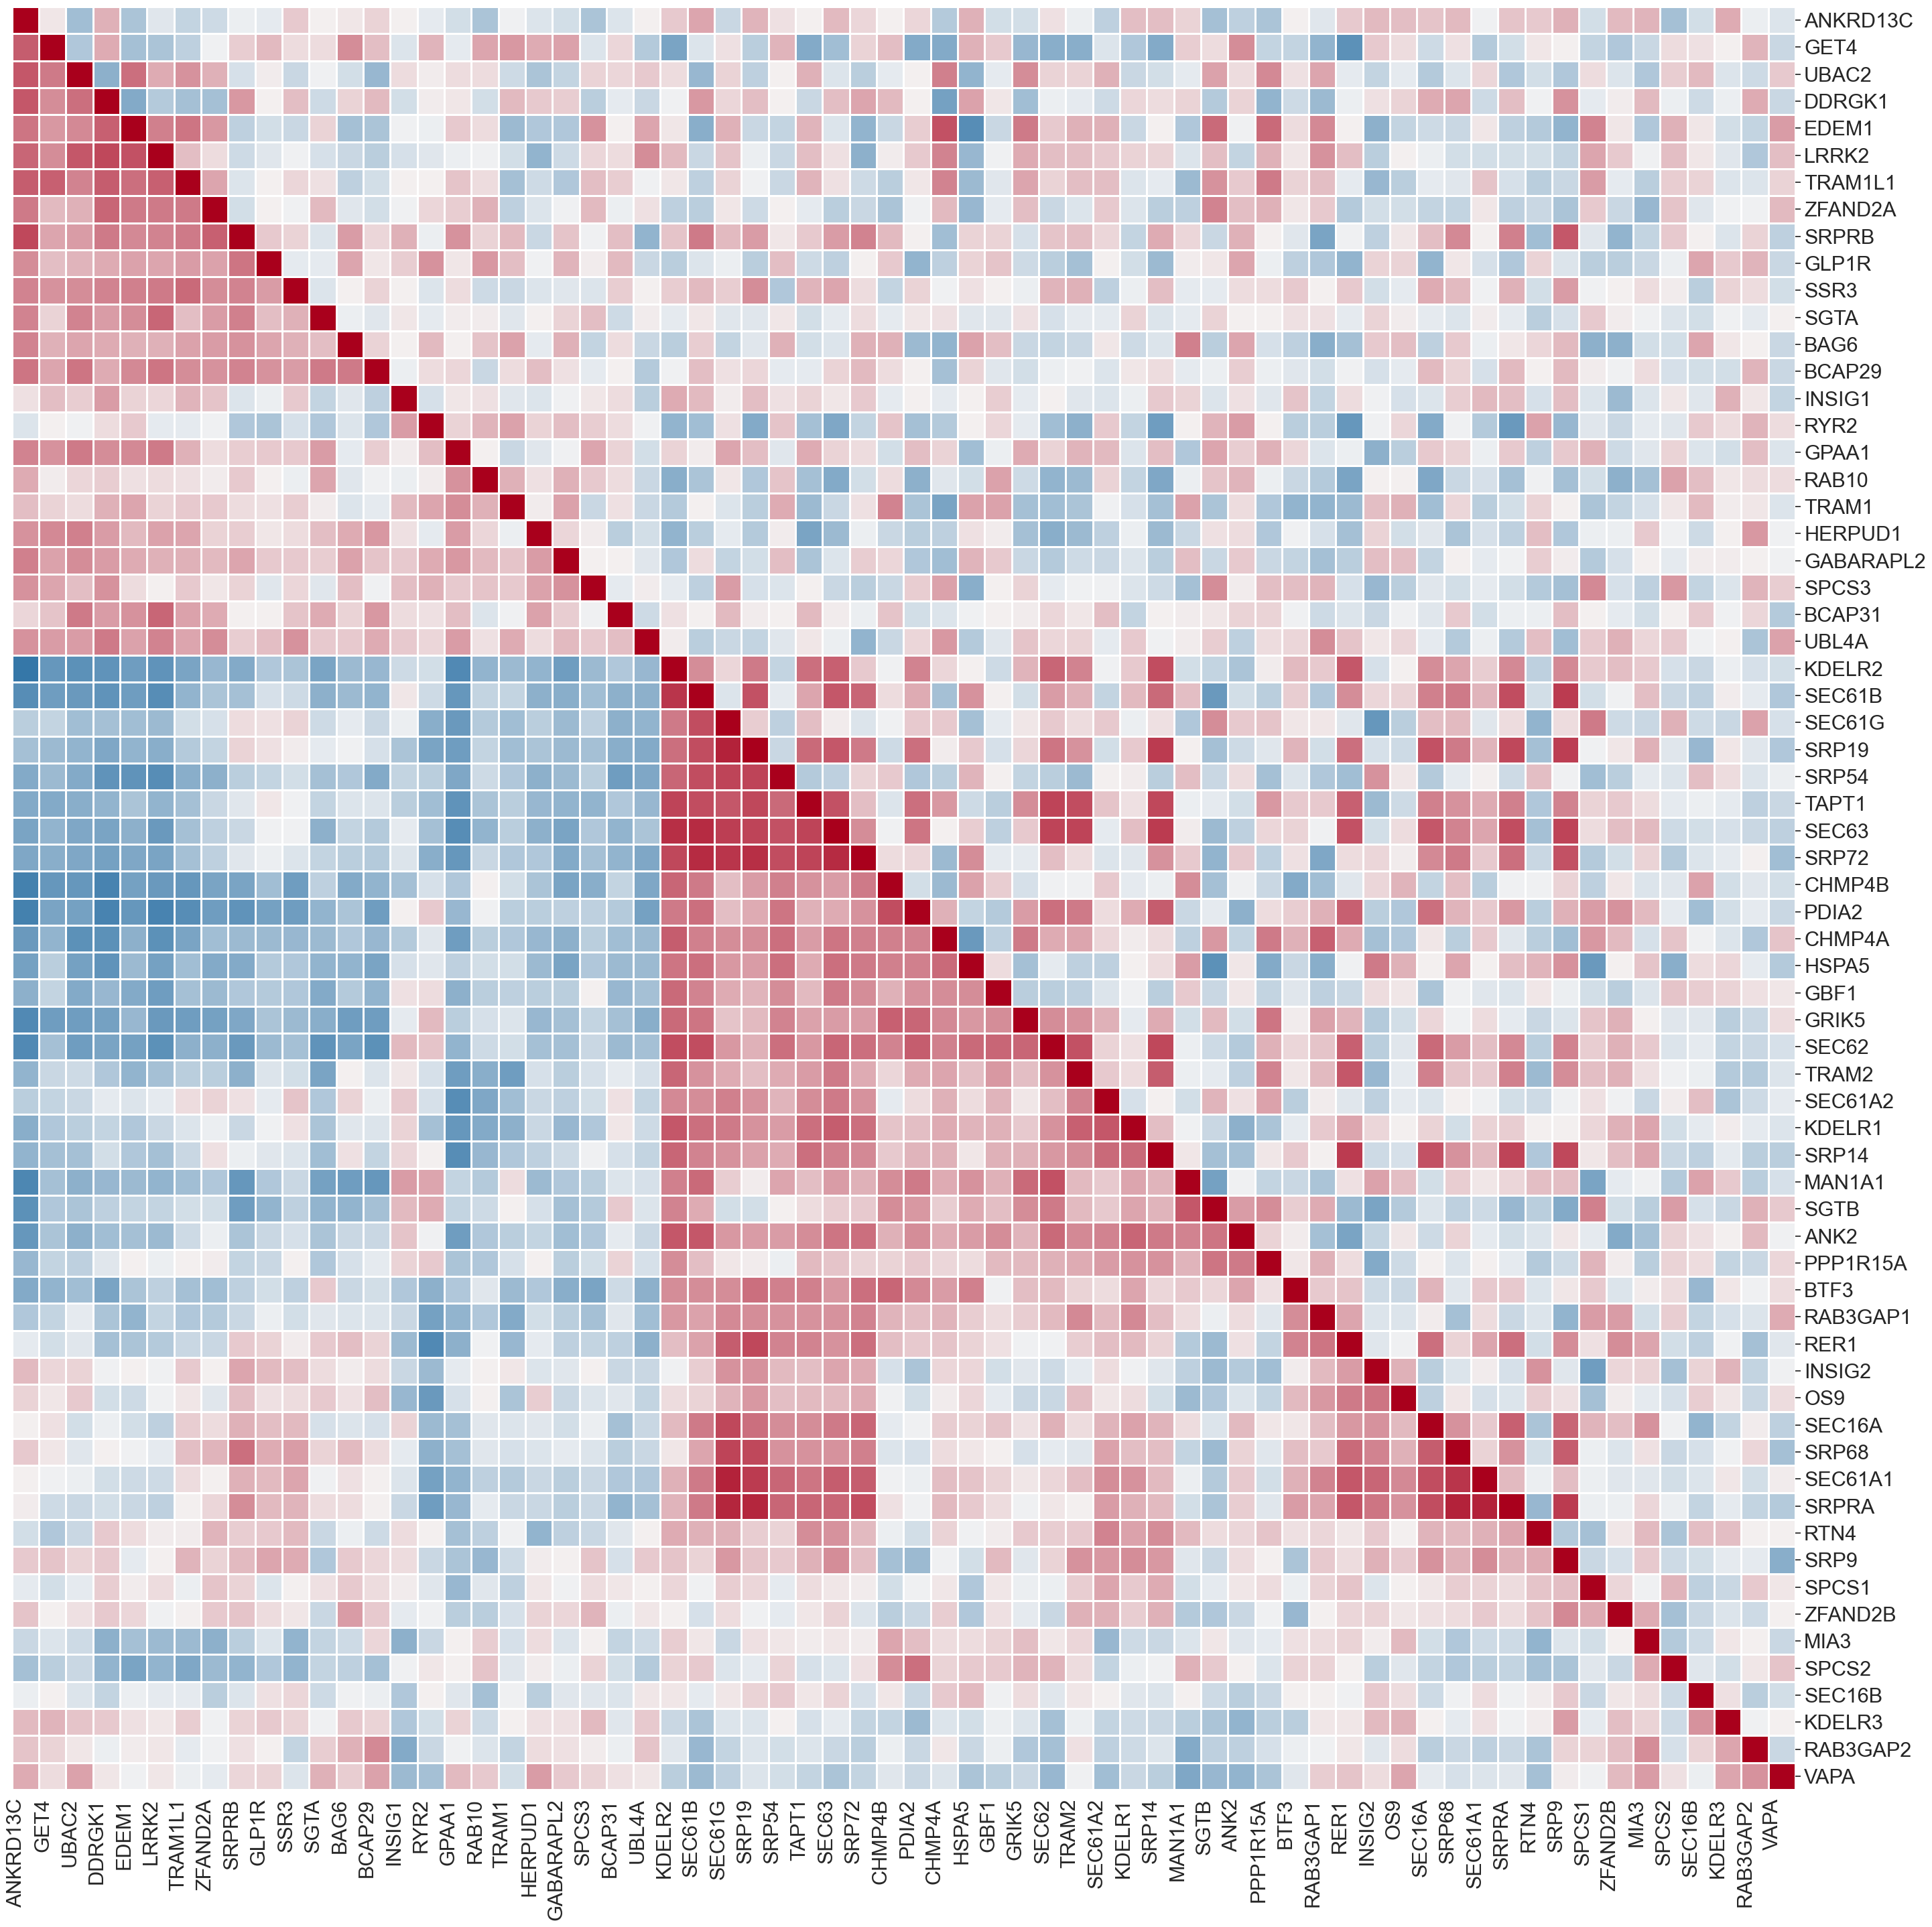

In [46]:
# Clustered based on the HPLM arm first
gene_set = 'PROTEIN_LOCALIZATION_TO_ENDOPLASMIC_RETICULUM'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first',4)


/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

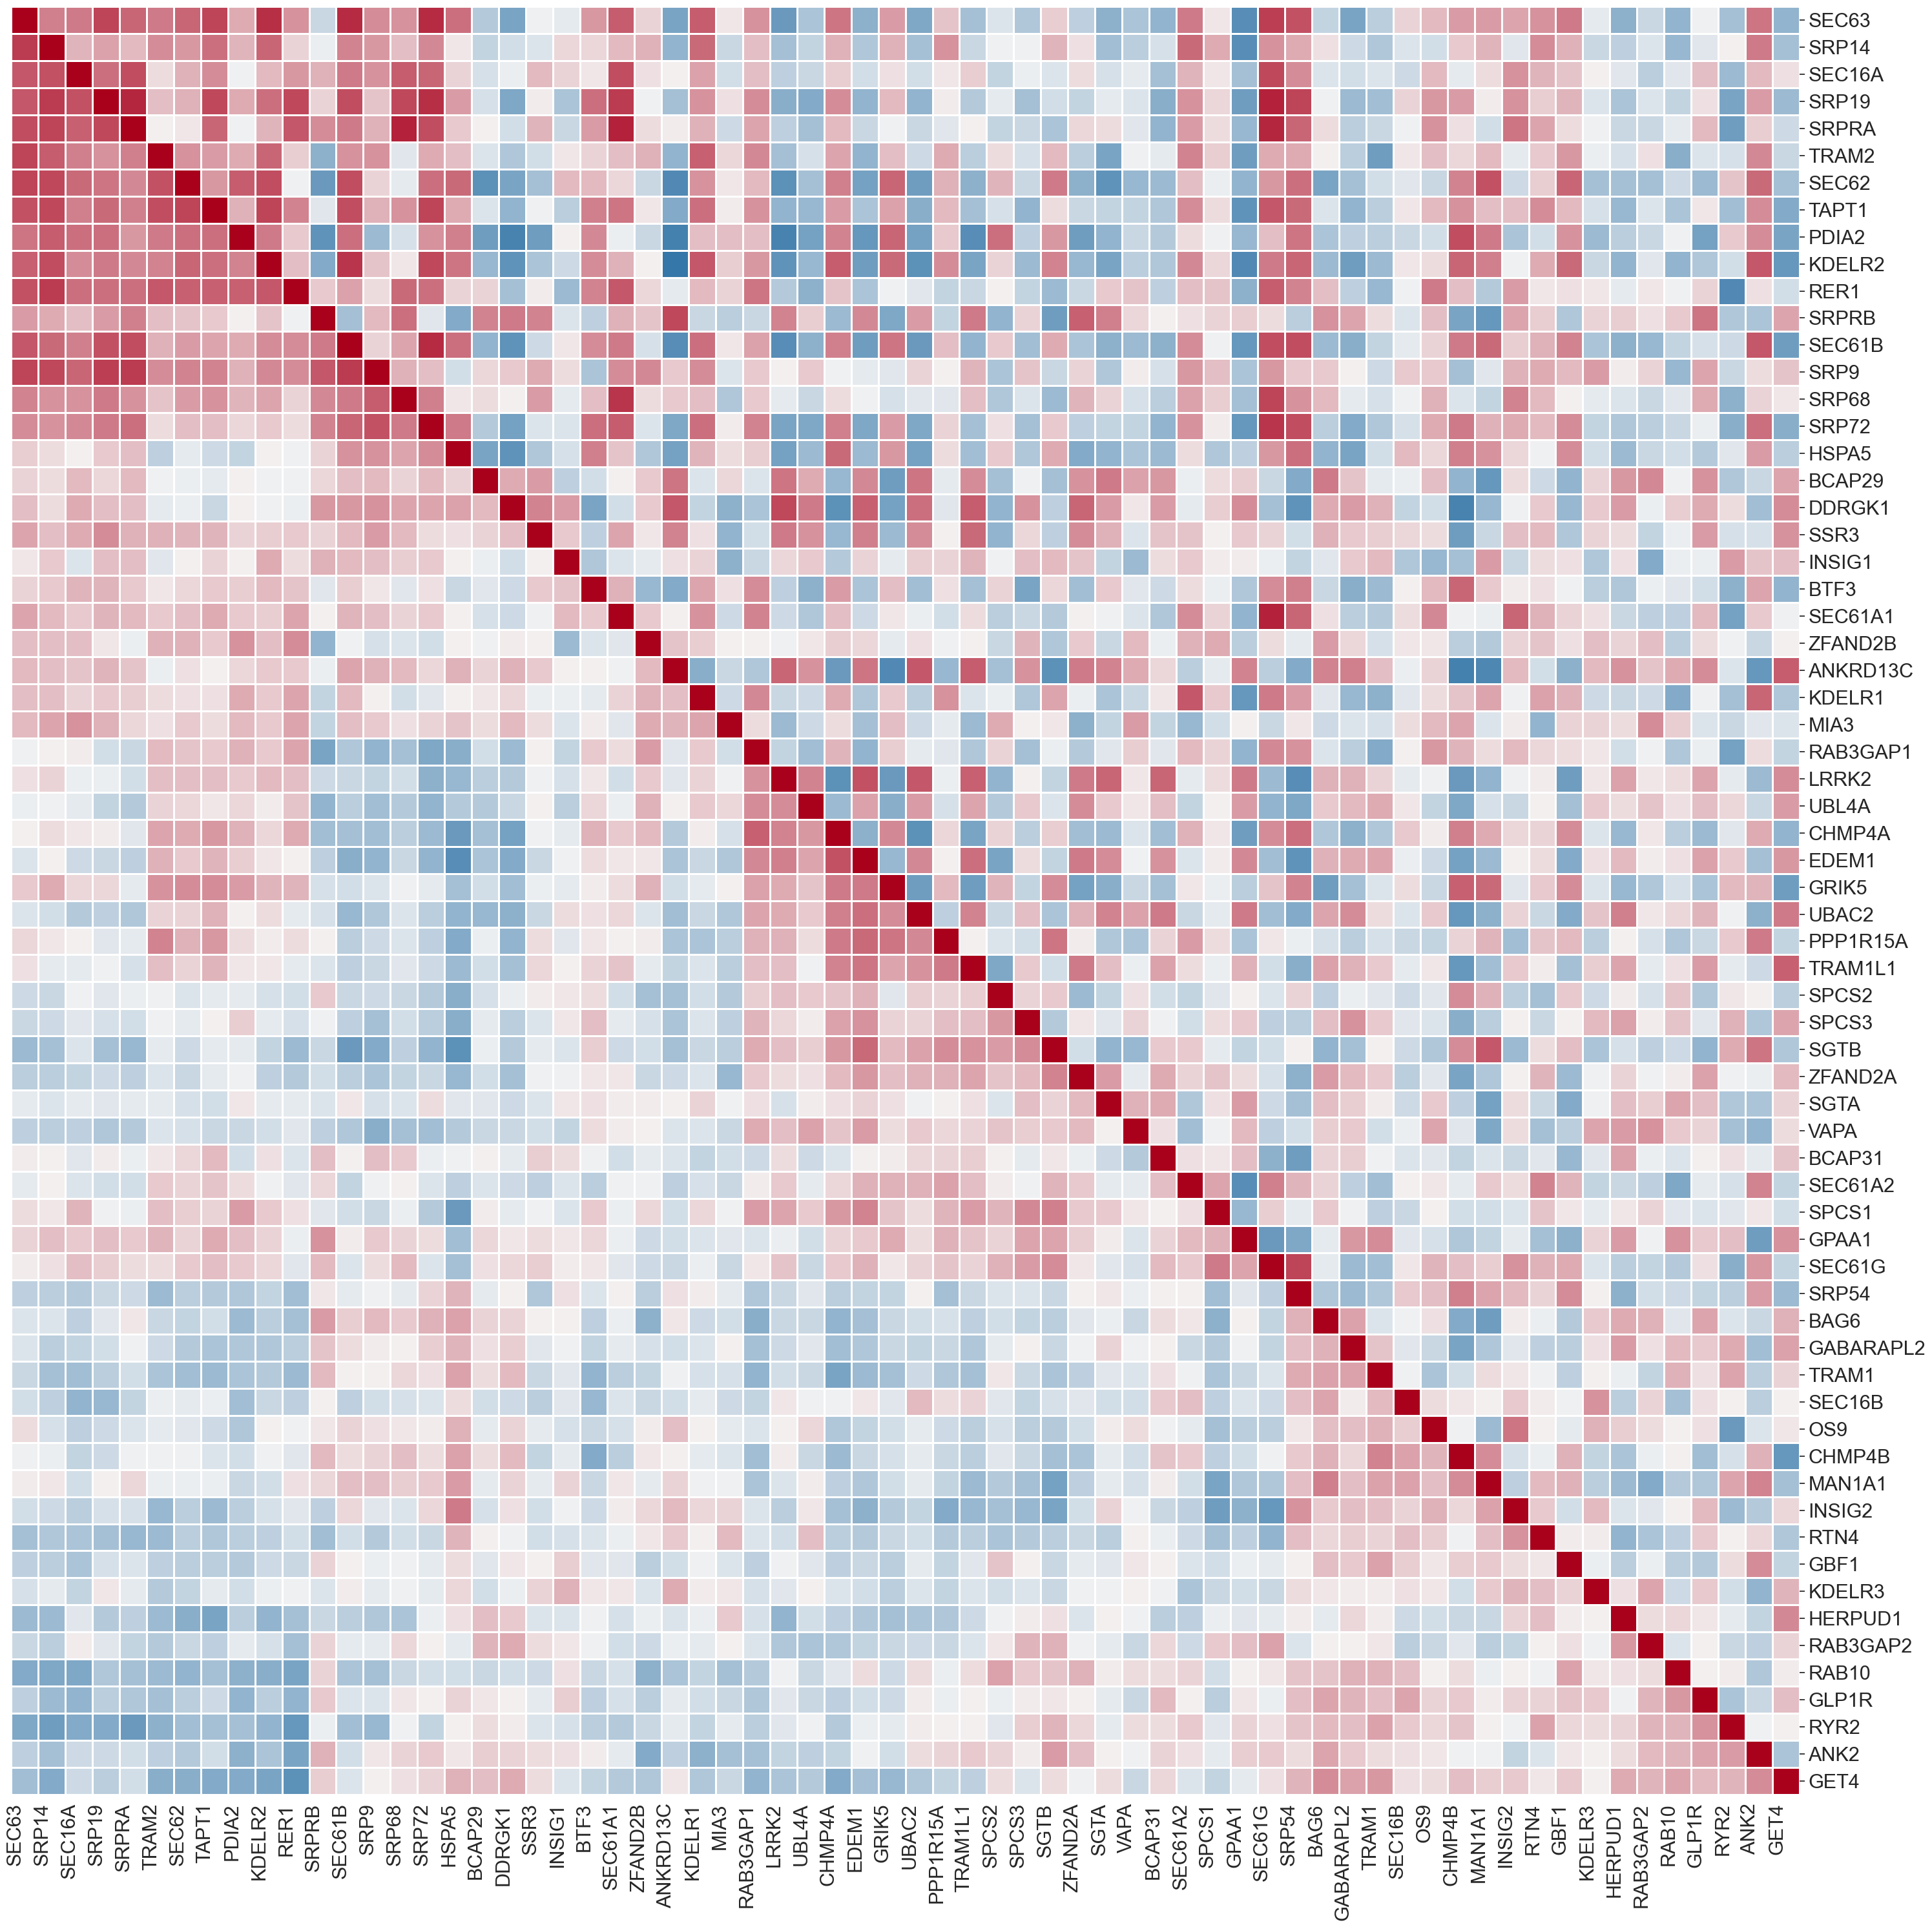

In [49]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',1)


/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

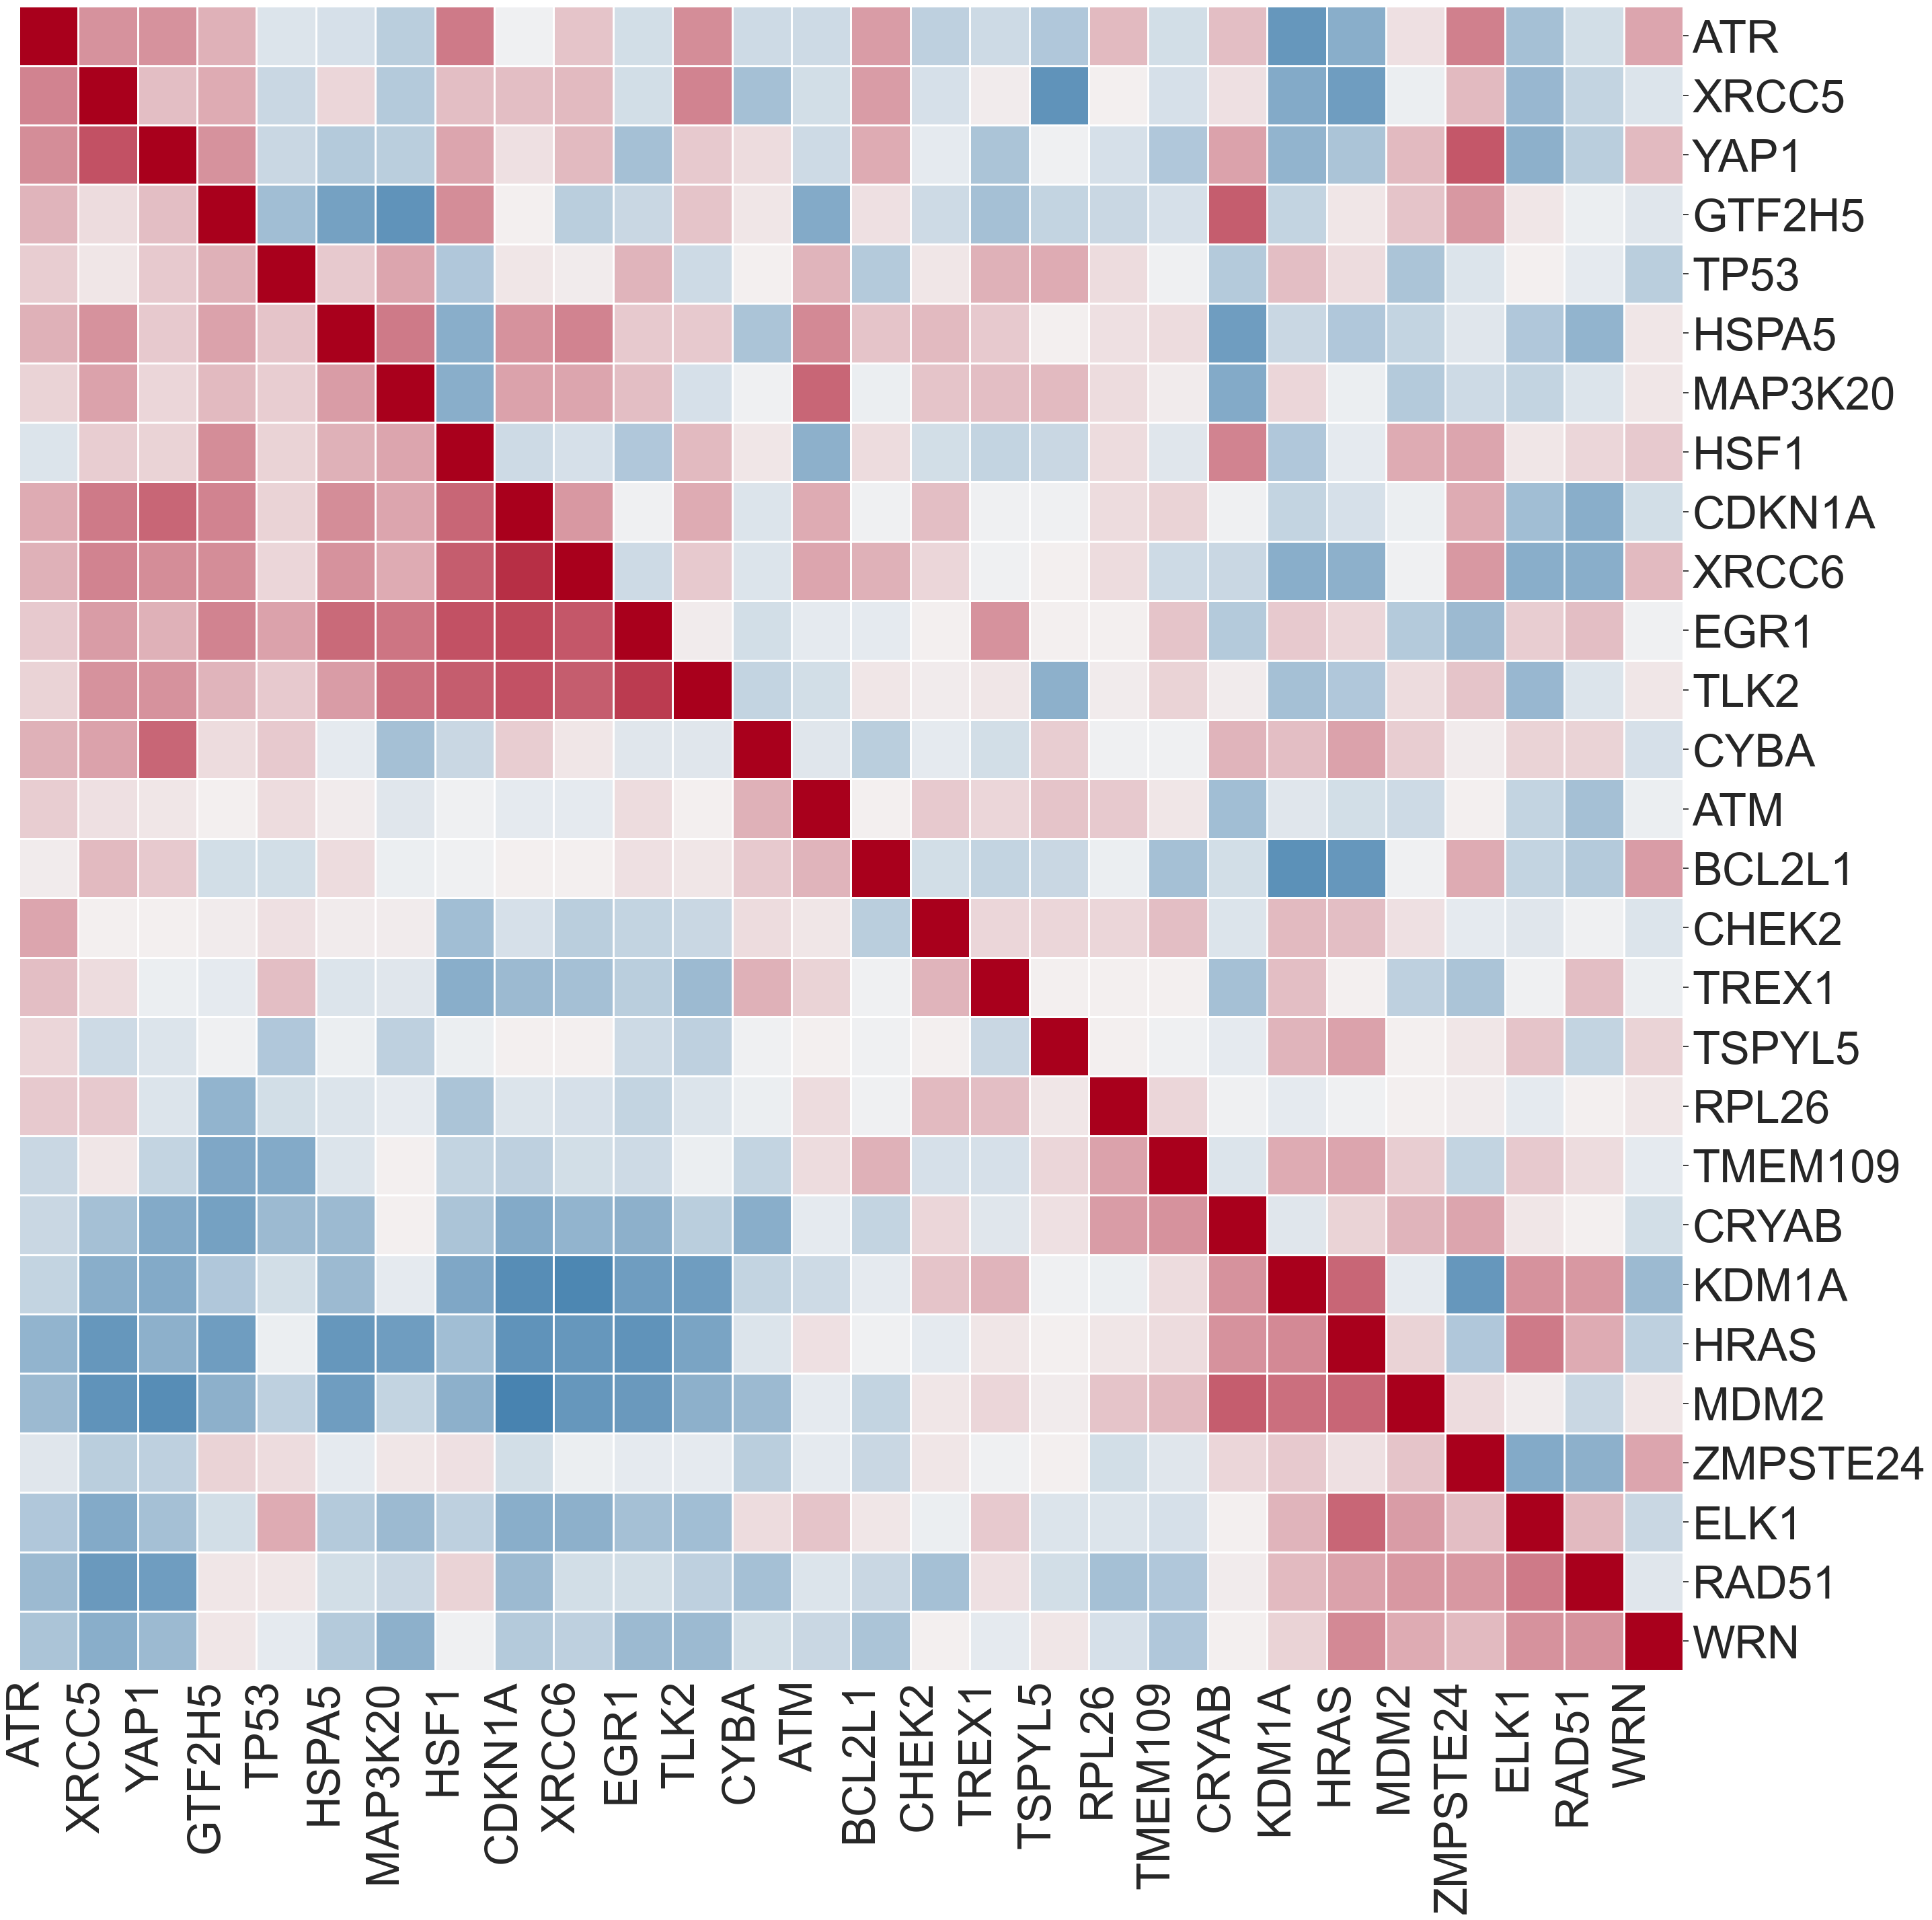

In [29]:
# Clustered based on the HPLM arm first
gene_set = 'CELLULAR_RESPONSE_TO_GAMMA_RADIATION'
genes = gene_set_dict[gene_set]
coupled_heatmap(df_gene_pca_dict['HPLM'],df_gene_pca_dict['DMEM'],gene_set,genes,'HPLM_first',4.4)


/Users/eweisbar/miniconda3/envs/periscope_2022/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

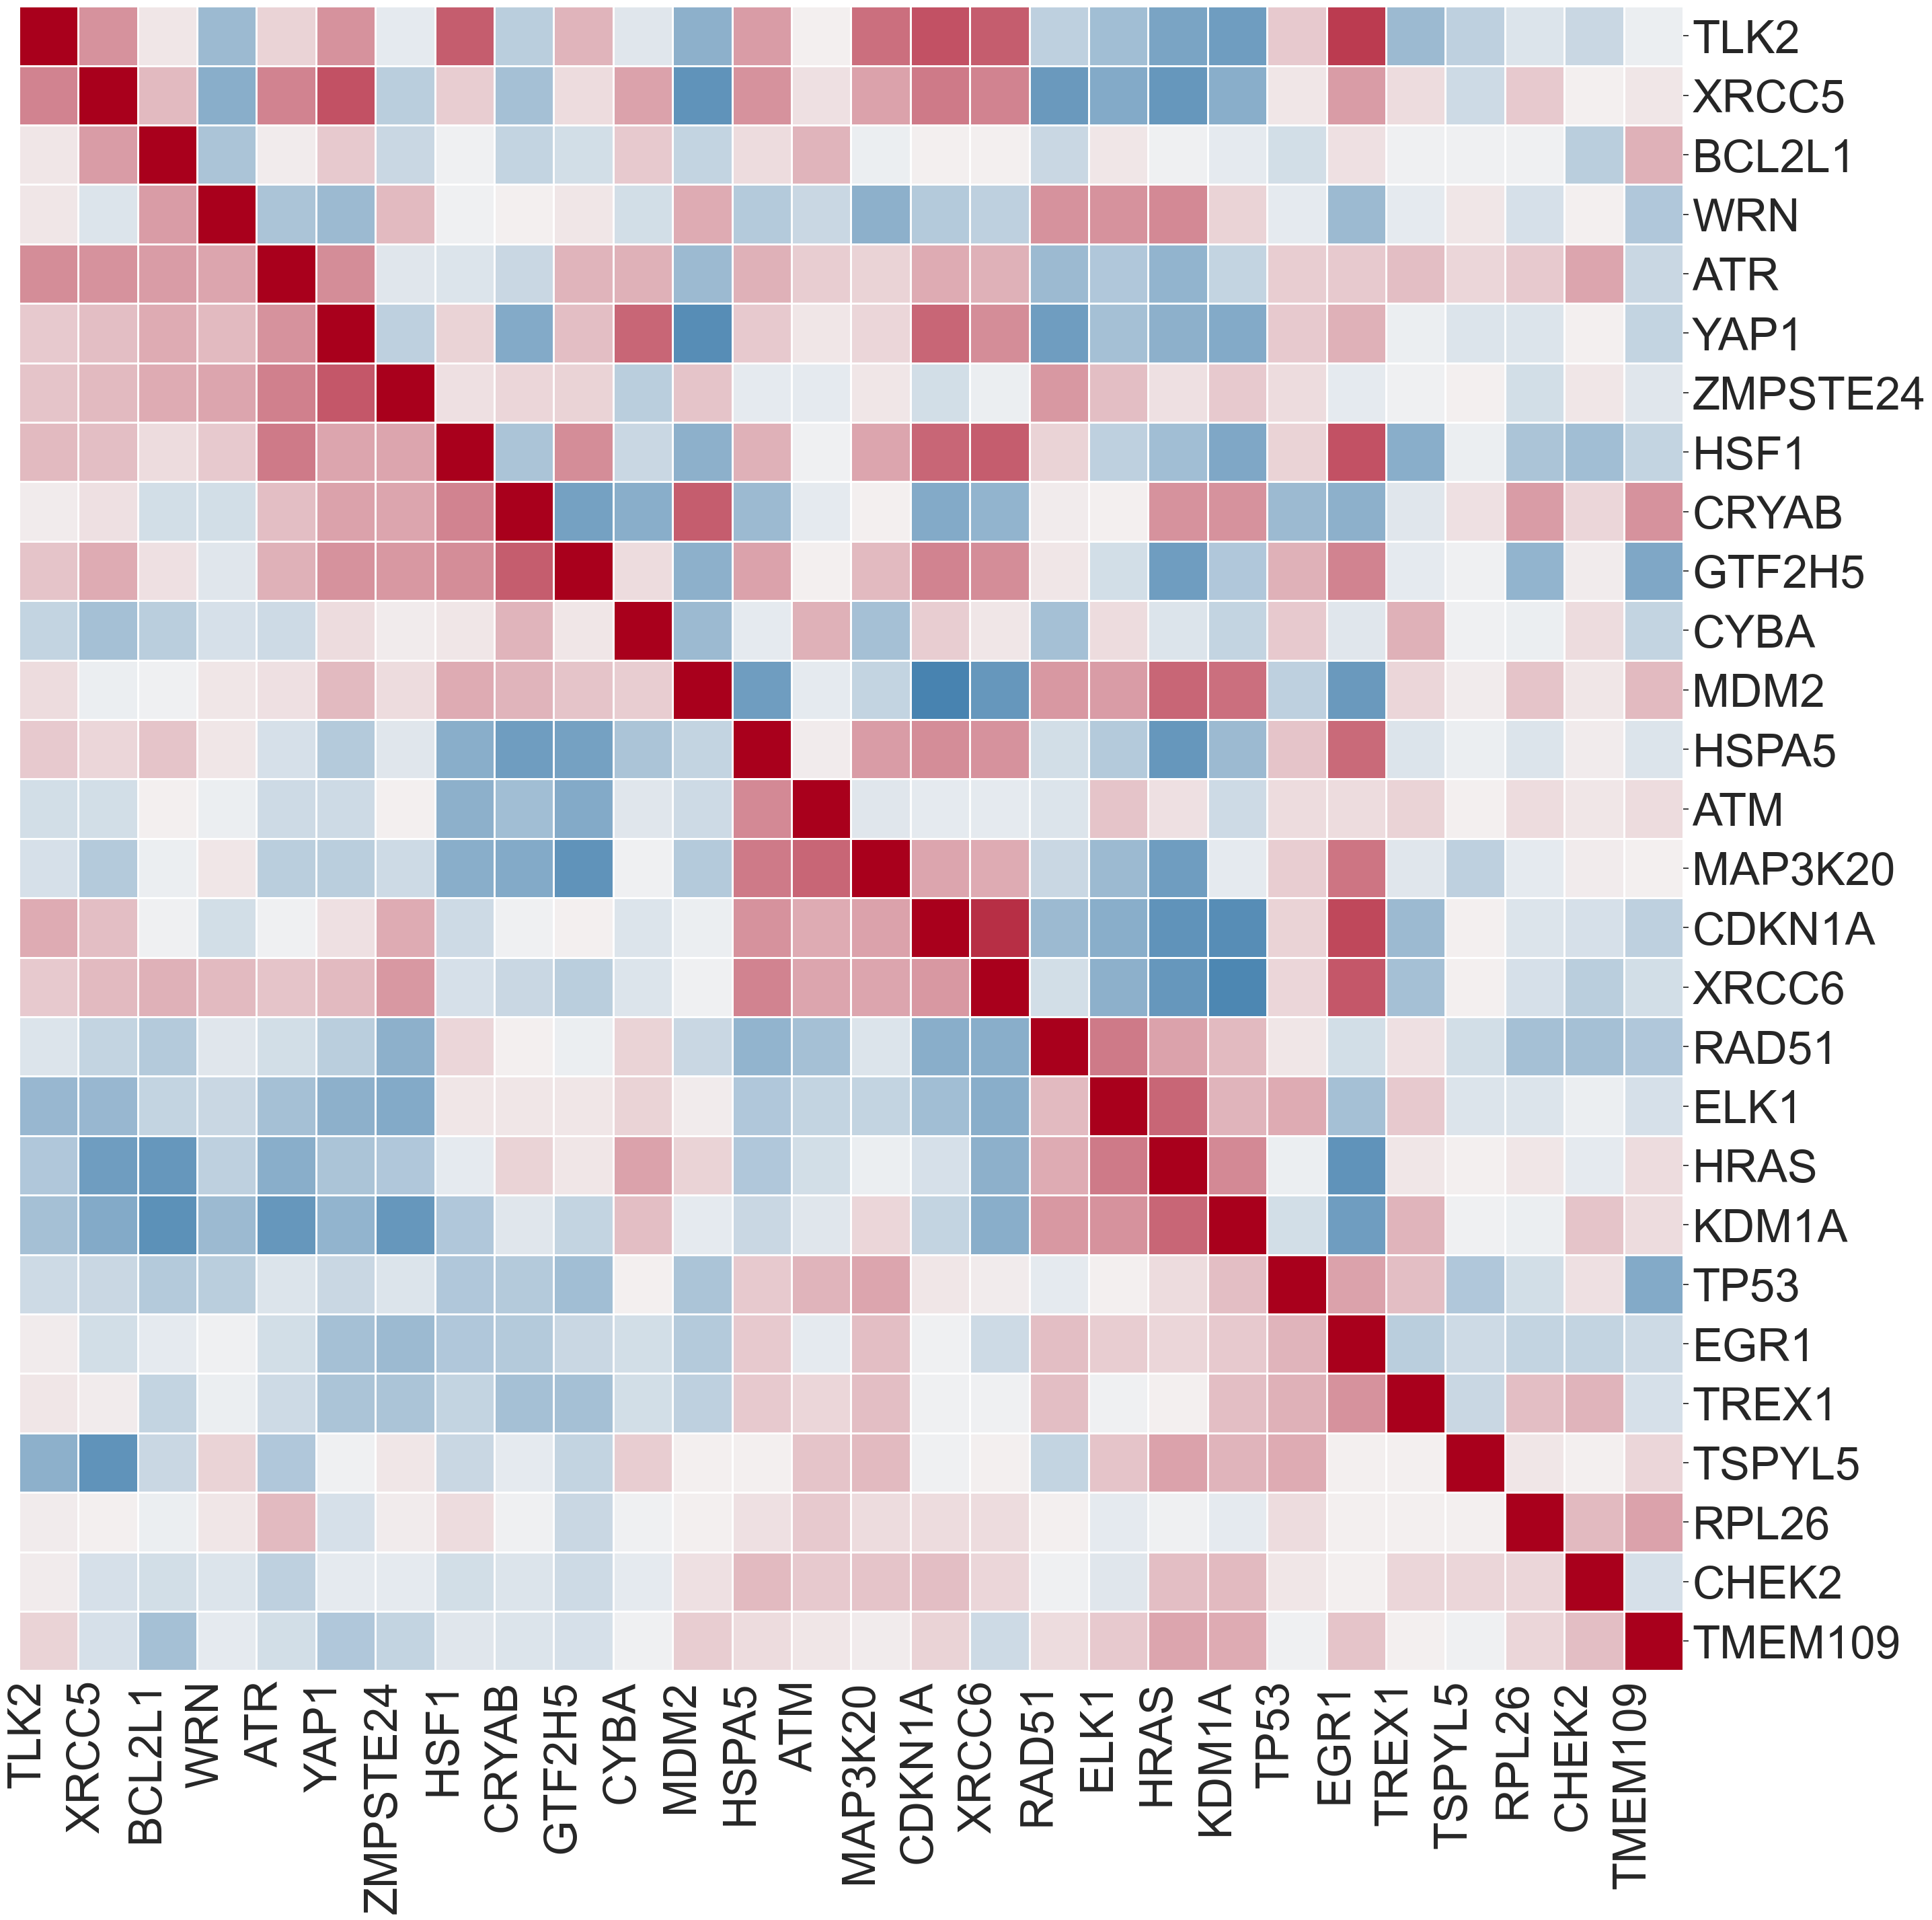

In [30]:
# Clustered based on the DMEM arm first
coupled_heatmap(df_gene_pca_dict['DMEM'],df_gene_pca_dict['HPLM'],gene_set,genes,'DMEM_first',4.4)
